# Fitting a computational model of momentary well-being to trial-by-trial affect ratings

During the reinforcement learning task, participants were about their subjective feelings after every trial. Specifically, after making a choice and receiving feedback, they were asked to rate from 0 to 100 how they felt with respect to three adjectives:

1. How **happy** are you at this moment?
2. How **confident** are you feeling in your answers at this moment?
3. How **engaged** are you feeling at this moment?

In each block of sixty trials, participants were asked each question exactly twenty times. The question order was randomised in groups of three such that each participant saw each question twice every six trials, and did not receive the same question more than twice in a row. Here we demonstrate that a computational model including quantities estimated from a Q-learning model fit to task choices can relatively accurately capture trial-by-trial fluctuations in affect ratings across the entire training phase.

## Setup

### Python dependencies

In [1]:
import os
os.chdir('..')
    # may need to be run initially if working directory is the notebook folder
%load_ext rpy2.ipython

### R dependencies and data

In [2]:
%%R
remotes::install_github(
    "qdercon/pstpipeline",
    quiet = TRUE,
    upgrade = "always"
)
# install.packages(c("patchwork", "ggtext"))
# cmdstanr::set_cmdstan_path("/root/cmdstan-2.28.1")
cmdstanr::set_cmdstan_path("/home/qd01/cmdstan/cmdstan-2.28.1") 
# extrafont::loadfonts(device = "win", quiet = TRUE) 
    # required on Windows to load additional fonts
options(width = 120)

R[write to console]: CmdStan path set to: /home/qd01/cmdstan/cmdstan-2.28.1



In [3]:
%%R
pal <- c("#ffc9b5", "#648767", "#b1ddf1", "#95a7ce", "#987284", "#3d5a80")
pal_contr <- c("#ffc9b5", "#95a7ce", "#987284")
pal_recovery <- c("#ffc9b5", "#b1ddf1", "#b6b8d6", "#498c8a", "#78ffd6")

all_res_split <- readRDS("data-raw/all_res_split.RDS")

# install.packages("sysfonts")
# sysfonts::font_add_google("Open Sans", "Open Sans")
# showtext::showtext_auto()

## Model fits

The computational model used here is a version of one proposed and validated by Rutledge *et al.* (2014) in [PNAS](https://www.pnas.org/doi/10.1073/pnas.1407535111). This model, specifically used to capture momentary happiness, suggests that subjective well-being at a given trial can be well-captured by a discounted (i.e., recent trials weighted higher) sum of expected values and prediction errors plus a baseline weight (i.e., intercept) term. Specifically, their proposed model is as follows,

\begin{equation*}
happiness_t = w_0 + w_1\sum_{j=1}^{t}{\gamma^{t-j}CR_j} + w_2\sum_{j=1}^{t}{\gamma^{t-j}EV_j} + w_3\sum_{j=1}^{t}{\gamma^{t-j}RPE_j},
\label{eq:rutledge2014} \tag{1}
\end{equation*}

where $t$ is the trial number, $\gamma$ is the discount or 'forgetting' factor, and $w$ the weights on each of the quantities of interest. It should be noted that in their task, rewards and losses were monetary, with the specific amounts won/lost available to participants on each trial, so the $EV$ and $RPE$ quantities could be calculated directly. In addition, there existed an option on each trial to take a "certain reward" ($CR$) rather than opt for a gamble.

In our task, meanwhile, expected values and prediction errors are not directly available to participants, but assumed to be computed nonetheless, with a dual learning-rate $Q$-learning model accounting well for individuals' choices. With our dataset, we were first able to answer a somewhat novel question: whether model-derived EVs and RPEs could similarly capture momentary fluctations in happiness during a reinforcement learning task. We also wondered whether fluctuations in the other affect nouns (confidence and engagement) could also be captured by such a model, perhaps with different weights. Lastly, we were interested if there may be any effect of cognitive distancing on weights estimated for each of the three affect nouns.

To do so, we first adapted Stan code for a hierarchical version of the above model from an independent replication of the original PNAS study by [Vanhasbroeck *et al.* (2021)](https://www.tandfonline.com/doi/full/10.1080/02699931.2021.1891863), which was deposited on [OSF](https://osf.io/9g2zw), to incorporate the dual learning-rate $Q$-learning model. Noting that, overall, affect ratings declined over the course of the task (e.g., due to fatigue), in a stepwise manner by block (the first rating in a block was on average highest), we included two extra (linear) intercept terms to account for time elapsed, both overall since the start of the task, and since the start of a given block. Such an effect has been seen in many similar studies with momentary affect ratings, and has recently been termed ["passage-of-time dysphoria"](https://psyarxiv.com/bwv58). The full model is as follows,

\begin{equation*}
affect_t = w_0 + w^{o}_{1}{time(o)_t} + w^{b}_{1}{time(b)_t}+ w_2\sum_{j=1}^{t}{\gamma^{t-j}Q_j(s_j, a_j)} + w_3\sum_{j=1}^{t}{\gamma^{t-j}[reward_j - Q_j(s_j, a_j)]},
\label{eq:extended} \tag{2}
\end{equation*}

where $affect_t$ is the rating at trial $t$ (between 0 and 1), and $time(o)_t$ and $time(b)_t$ refer to time (in hours) elapsed overall until trial $t$, and time elapsed since the start of the block containing trial $t$ respectively. $Q_j(s_j, a_j)$ and $reward_j - Q_j(s_j, a_j)$ are the $Q$-learning model-derived expected value and prediction error on trial $j$. Note that, in contrast to model fits for the $Q$-learning model alone (in other notebooks), rewards are coded as 1 or -1, to allow for negative expected value estimates.

For the purposes of model comparison we fit five different variants of this model, including the original model $\eqref{eq:rutledge2014}$, extended variants with constants on trial number or block number, the original passage of time model (with $w^{o}_{1}$ alone), and the full model $\eqref{eq:extended}$. It should be noted that we use automatic differentiation variational inference ([ADVI](https://www.jmlr.org/papers/volume18/16-107/16-107.pdf)) implemented in CmdStan to fit these models throughout, due to the complexity making MCMC computationally unreasonable (i.e., 18 free parameters of interest for each individual, plus $Q$-learning model parameters and many other distributional parameters at the group- and individual-level). The models were compared using the leave-one-out information criterion with a correction for approximate inference implemented in the *loo* R package (see [this vignette](https://mc-stan.org/loo/articles/loo2-large-data.html)).

Given our previous findings of learning rate asymmetry between groups, models were fit separately in non-distanced and distanced participants, but within each group the models were fit on ratings for all three questions together, with separate weights and decay factors assumed for each person and question.

### Non-distanced participants

In [4]:
%%R
head(tibble::as_tibble(all_res_split$non_distanced$ppt_info))

# A tibble: 6 × 78
  subjID sessi…¹ studyID dista…² exclu…³ final…⁴ final…⁵ final…⁶ total…⁷ total…⁸ keypr…⁹ mean_rt digit…˟ catch…˟ catch…˟
  <chr>  <chr>   <chr>   <lgl>     <dbl>   <dbl>   <dbl>   <dbl>   <int>   <dbl>   <dbl>   <dbl>   <int> <lgl>   <lgl>  
1 a82f8… 6081a5… 608027… FALSE         0    0.5    0.526    0.5     4575    94.8    54.0    713.       7 TRUE    TRUE   
2 7516c… 60816b… 60801c… FALSE         0    0.55   0.579    0.6     4625    65.4    50      360.       7 TRUE    TRUE   
3 b5df6… 60816c… 608025… FALSE         0    0.7    0.55     0.55    4600    85.7    60.8    476.       7 TRUE    TRUE   
4 3c1c4… 60817d… 608028… FALSE         0    0.5    0.8      0.8     4900    91.4    57.0   1941.       9 TRUE    TRUE   
5 8fb49… 608178… 608027… FALSE         0    0.9    0.95     0.2     4875    88.3    55      780.       5 TRUE    TRUE   
6 12252… 608177… 608026… FALSE         0    0.85   0.35     0.55    4375   132.     55.9   1002.       6 TRUE    TRUE   
# … with 63 m

#### Original model

In [5]:
%%R
vb_affect_nd_m1 <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "3wt", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m1"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.22512 seconds 
1000 transitions using 10 leapfrog steps per transition would take 22251.2 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  

#### Model with linear weight on trial number

In [6]:
%%R
vb_affect_nd_m2 <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", iter = 15000, # issues w convergence
    affect = TRUE, affect_sfx = "4wt_trial", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m2"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.14093 seconds 
1000 transitions using 10 leapfrog steps per transition would take 21409.3 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   

#### Model with linear weight on block number

In [7]:
%%R
vb_affect_nd_m3 <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "4wt_block", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m3"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 1.89891 seconds 
1000 transitions using 10 leapfrog steps per transition would take 18989.1 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -588979.449             1.000            1.000 
   2

#### Model with linear weight on total time elapsed (in hours)

Time elapsed was coded as hours so that the resulting coefficients were on a similar scale to other weights.

In [8]:
%%R
vb_affect_nd_m4 <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "4wt_time", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m4"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.20976 seconds 
1000 transitions using 10 leapfrog steps per transition would take 22097.6 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100       -63129.321             1.000            1.000 
   200        -8191

#### Model with linear weights on time elapsed, in total and since the start of the block

In [9]:
%%R
vb_affect_nd_m5 <- pstpipeline::fit_learning_model(
    all_res_split$non_distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "5wt_time", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.27613 seconds 
1000 transitions using 10 leapfrog steps per transition would take 22761.3 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -447194.940             1.000            1.000 
   200      -325103.276             0.688            1.000 
   300      -254460.37

### Distanced participants

In [10]:
%%R
head(tibble::as_tibble(all_res_split$distanced$ppt_info))

# A tibble: 6 × 78
  subjID sessi…¹ studyID dista…² exclu…³ final…⁴ final…⁵ final…⁶ total…⁷ total…⁸ keypr…⁹ mean_rt digit…˟ catch…˟ catch…˟
  <chr>  <chr>   <chr>   <lgl>     <dbl>   <dbl>   <dbl>   <dbl>   <int>   <dbl>   <dbl>   <dbl>   <int> <lgl>   <lgl>  
1 77fba… 608181… 608028… TRUE          0    0.8    0.65     0.6     4825    75.6    58.1   1211.       8 TRUE    TRUE   
2 9fdbd… 60817c… 608028… TRUE          0    1      0.95     0.55    5550    72.9    58.6   1106.       7 TRUE    TRUE   
3 4dd64… 60817c… 60801d… TRUE          1    0.55   0.35     0.5     4400    55.7    50.6    221.       9 TRUE    TRUE   
4 54a89… 60817b… 60801f… TRUE          0    0.8    0.8      0.55    5225    95.6    53.9    927.       8 TRUE    TRUE   
5 96bee… 608178… 608028… TRUE          0    0.55   0.368    0.7     4400   107.     55.2    884.       5 TRUE    TRUE   
6 9c3e6… 608177… 608026… TRUE          0    0.5    0.7      0.5     4100    72.3    58.5    432.       5 TRUE    TRUE   
# … with 63 m

#### Original model

In [11]:
%%R
vb_affect_dis_m1 <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "3wt", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m1"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\| 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 1.97215 seconds 
1000 transitions using 10 leapfrog steps per transition would take 19721.5 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100       -62156.926             1.000            1.000 
   200       -21198.748       

#### Model with linear weight on trial number

In [12]:
%%R
vb_affect_dis_m2 <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", iter = 25000, # issues w convergence
    affect = TRUE, affect_sfx = "4wt_trial", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m2"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.03929 seconds 
1000 transitions using 10 leapfrog steps per transition would take 20392.9 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100     -1301725.814             1.000            1.000 
   200      -977006.504             0.666            1.000 
   300      -833670.15

#### Model with linear weight on block number

In [13]:
%%R
vb_affect_dis_m3 <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "4wt_block", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m3"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\| 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 1.87505 seconds 
1000 transitions using 10 leapfrog steps per transition would take 18750.5 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -587537.789             1.000            1.

#### Model with linear weight on total time elapsed (in hours)

In [14]:
%%R
vb_affect_dis_m4 <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "4wt_time", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m4"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\| 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.36399 seconds 
1000 transitions using 10 leapfrog steps per transition would take 23639.9 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -293182.630             1.000            1.000 
   200       -32629.581   

#### Model with linear weights on time elapsed, in total and since the start of the block

In [15]:
%%R
vb_affect_dis_m5 <- pstpipeline::fit_learning_model(
    all_res_split$distanced, model = "1a", exp_part = "training", 
    affect = TRUE, affect_sfx = "5wt_time", vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list", "loo_obj"),
    out_dir = "outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 2.03331 seconds 
1000 transitions using 10 leapfrog steps per transition would take 20333.1 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -425394.896             1.000            1.000 
  

## Model comparison

See the other notebook (```affect_model_vb_2a.ipynb```) for dual learning rate $Q$-learning models and their association with quantities of interest.

In [16]:
%%R
## non-distanced
loo_obj_nd_m1 <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m1/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_nd_m2 <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m2/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_nd_m3 <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m3/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_nd_m4 <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m4/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_nd_m5 <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_nd_m6 <- readRDS("outputs/cmdstan/affect_2a/non-distanced/model_fits/model_comp/m1/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_nd_m7 <- readRDS("outputs/cmdstan/affect_2a/non-distanced/model_fits/model_comp/m2/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_nd_m8 <- readRDS("outputs/cmdstan/affect_2a/non-distanced/model_fits/model_comp/m3/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_nd_m9 <- readRDS("outputs/cmdstan/affect_2a/non-distanced/model_fits/model_comp/m4/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_nd_m10 <- readRDS("outputs/cmdstan/affect_2a/non-distanced/model_fits/model_comp/m5/fit_pst_training_2a_vb_loo_obj.RDS")
affect_nd_comp <- loo::loo_compare(loo_obj_nd_m1, loo_obj_nd_m2, loo_obj_nd_m3, loo_obj_nd_m4, loo_obj_nd_m5, 
                                   loo_obj_nd_m6, loo_obj_nd_m7, loo_obj_nd_m8, loo_obj_nd_m9, loo_obj_nd_m10)

## distanced
loo_obj_dis_m1 <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m1/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_dis_m2 <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m2/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_dis_m3 <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m3/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_dis_m4 <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m4/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_dis_m5 <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_loo_obj.RDS")
loo_obj_dis_m6 <- readRDS("outputs/cmdstan/affect_2a/distanced/model_fits/model_comp/m1/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_dis_m7 <- readRDS("outputs/cmdstan/affect_2a/distanced/model_fits/model_comp/m2/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_dis_m8 <- readRDS("outputs/cmdstan/affect_2a/distanced/model_fits/model_comp/m3/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_dis_m9 <- readRDS("outputs/cmdstan/affect_2a/distanced/model_fits/model_comp/m4/fit_pst_training_2a_vb_loo_obj.RDS")
loo_obj_dis_m10 <- readRDS("outputs/cmdstan/affect_2a/distanced/model_fits/model_comp/m5/fit_pst_training_2a_vb_loo_obj.RDS")
affect_dis_comp <- loo::loo_compare(loo_obj_dis_m1, loo_obj_dis_m2, loo_obj_dis_m3, loo_obj_dis_m4, loo_obj_dis_m5,
                                   loo_obj_dis_m6, loo_obj_dis_m7, loo_obj_dis_m8, loo_obj_dis_m9, loo_obj_dis_m10)

In [17]:
%%R
print(affect_nd_comp, digits = 1, simplify = FALSE)
print(affect_dis_comp, digits = 1, simplify = FALSE)

        elpd_diff se_diff   elpd_loo  se_elpd_loo p_loo     se_p_loo  looic     se_looic 
model5        0.0       0.0   64225.6    3690.5      5356.4     251.2 -128451.3    7380.9
model10   -5100.9     807.8   59124.7    3384.7      9596.8     474.5 -118249.5    6769.3
model3    -5353.3     460.7   58872.3    3584.3      7317.8     320.6 -117744.6    7168.5
model4    -6273.2     654.6   57952.4    3373.8      7968.3     331.3 -115904.9    6747.7
model9    -6625.5     792.2   57600.1    3311.6      8880.6     402.7 -115200.2    6623.2
model8    -8130.7     865.5   56095.0    3274.5      9746.2     414.6 -112190.0    6548.9
model6   -14070.5    1132.9   50155.2    3572.0      6932.7     373.9 -100310.4    7144.1
model2   -14664.1    1029.0   49561.5    3196.0     12616.4     585.6  -99123.1    6392.0
model7   -17934.4    1141.7   46291.3    3133.9     15820.9     730.2  -92582.6    6267.8
model1   -21165.9    1275.8   43059.7    3624.2      7712.0     327.8  -86119.4    7248.4
        el

In both groups, there is evidence from both the ELPD and LOOIC that the full model best fits the question responses, with the single learning rate model sightly favoured over the dual learning rate model.

## Check fits

#### Get posterior predictions and summaries

In [18]:
%%R
## non-distanced
draws_df_nd   <- posterior::as_draws_df(
    readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_draws_list.RDS")
)
summary_df_nd <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_summary.RDS")
raw_df_nd <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_raw_df.RDS")

## distanced
draws_df_dis   <- posterior::as_draws_df(
    readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_draws_list.RDS")
)
summary_df_dis <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_summary.RDS")
raw_df_dis <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_raw_df.RDS")

In [19]:
%%R
fits <- list()
fits$nd <- list()
fits$dis <- list()

for (adj in c("happy", "confident", "engaged")) {
    fits$nd[[adj]] <- pstpipeline::get_affect_ppc(draws_df_nd, raw_df_nd, adj = adj)
    fits$dis[[adj]] <- pstpipeline::get_affect_ppc(draws_df_dis, raw_df_dis, adj = adj)
}
saveRDS(fits, "outputs/cmdstan/affect_1a/fit_dfs_all.RDS")

  |==============================================================================================================| 100%

In [20]:
%%R
fits_all <- 
    dplyr::bind_rows(
        fits$nd$happy$fit_df |> dplyr::mutate(grp = "non-distanced", adj = "happy"),
        fits$dis$happy$fit_df |> dplyr::mutate(grp = "distanced", adj = "happy")
    ) |>
    dplyr::bind_rows(
        fits$nd$confident$fit_df |> dplyr::mutate(grp = "non-distanced", adj = "confident"),
        fits$dis$confident$fit_df |> dplyr::mutate(grp = "distanced", adj = "confident")
    ) |>
    dplyr::bind_rows(
        fits$nd$engaged$fit_df |> dplyr::mutate(grp = "non-distanced", adj = "engaged"),
        fits$dis$engaged$fit_df |> dplyr::mutate(grp = "distanced", adj = "engaged")
    )

In [21]:
%%R
library(rlang, quietly = TRUE, warn.conflicts = FALSE)
stats <- list()
for (stat in c("R2", "MAE", "RMSE")) {
    s <- rlang::sym(stat)
    stats[[stat]] <- fits_all |> 
        dplyr::group_by(adj, grp) |> 
        dplyr::summarise(
            n = dplyr::n(), 
            NAs = sum(is.na(!!s)), 
            median = median(!!s, na.rm = TRUE), 
            mean = mean(!!s, na.rm = TRUE),
            sd = sd(!!s, na.rm = TRUE),
            min = min(!!s, na.rm = TRUE),
            max = max(!!s, na.rm = TRUE),
            .groups = "keep"
        )
}
stats

$R2
# A tibble: 6 × 9
# Groups:   adj, grp [6]
  adj       grp               n   NAs median  mean    sd        min   max
  <chr>     <chr>         <int> <int>  <dbl> <dbl> <dbl>      <dbl> <dbl>
1 confident distanced       459     1  0.373 0.384 0.225 0.0000926  0.907
2 confident non-distanced   476     2  0.362 0.371 0.216 0.000104   0.899
3 engaged   distanced       459     0  0.314 0.359 0.247 0.0000657  0.899
4 engaged   non-distanced   476     3  0.368 0.387 0.239 0.000422   0.941
5 happy     distanced       459     1  0.329 0.349 0.227 0.00000346 0.881
6 happy     non-distanced   476     1  0.382 0.388 0.227 0.0000108  0.912

$MAE
# A tibble: 6 × 9
# Groups:   adj, grp [6]
  adj       grp               n   NAs median  mean    sd   min   max
  <chr>     <chr>         <int> <int>  <dbl> <dbl> <dbl> <dbl> <dbl>
1 confident distanced       459     0   7.27  7.94  4.09 0.749  36.5
2 confident non-distanced   476     0   7.01  7.65  3.73 0.127  27.8
3 engaged   distanced       459     

Based on predictions sampled from the approximate posterior (1,000 samples), the model is able to capture variablility in question responses relatively well, with mean ($\pm$ SD) $R^2\geq0.35~(\pm~0.2)$ for all adjectives in both groups, including mean $R^2=0.38$ for happiness in non-distanced individuals. Considering that expected values and reward prediction errors were inferred entirely from the $Q$-learning model, as opposed to appearing on the screen as monetary amounts (as in previous work), this compares rather favourably to the mean $R^2=0.47~(\pm~0.21)$ originally reported by [Rutledge *et al.* (2014)](https://www.pnas.org/doi/10.1073/pnas.1407535111), especially when we consider their model was fitted separately to each participant's reponses for happiness alone, and our model is conservatively fit across all participants hierarchically and with approximate inference.

### Mean predictions compared to raw affect ratings, by group

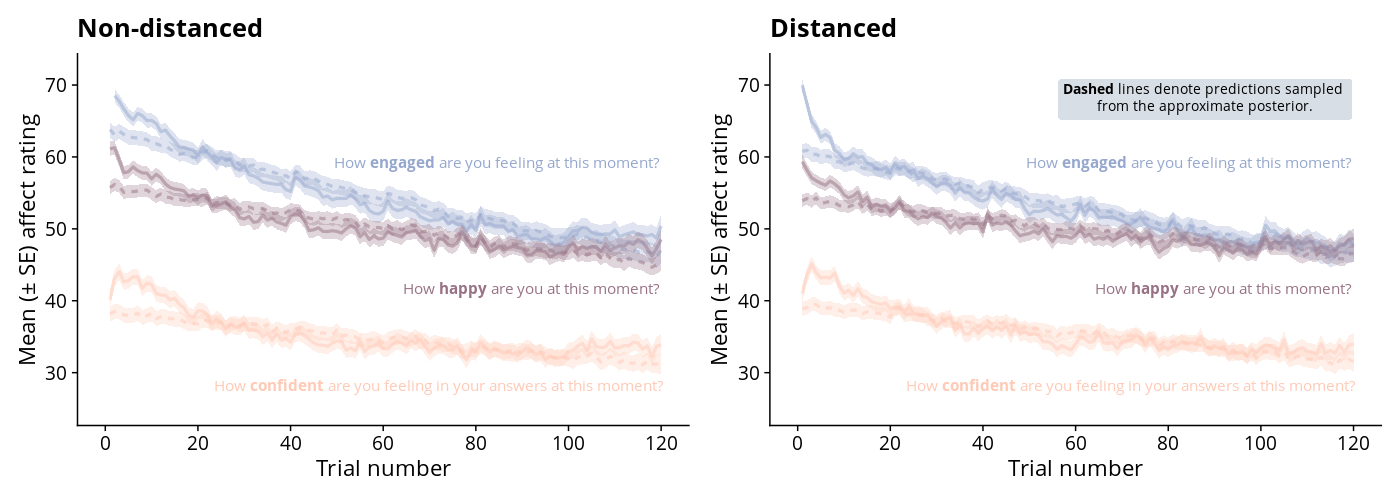

In [22]:
%%R -w 14 -h 5 --units in -r 100
# fits <- readRDS("outputs/cmdstan/affect_1a/fit_dfs_all.RDS")
library(ggtext)
library(patchwork)

happ_label <- "<p style='font-size:11pt; color:#987284'>How <strong>happy</strong> are you at this moment?</p>"
conf_label <- "<p style='font-size:11pt; color:#ffc9b5'>How <strong>confident</strong> are you feeling in your answers at this moment?</p>"
bored_label <- "<p style='font-size:11pt; color:#95a7ce'>How <strong>engaged</strong> are you feeling at this moment?</p>"

expl <- "<p style='font-size:10pt; line-height:1.2; color:black'><strong>Dashed</strong> lines denote predictions sampled <br>from the approximate posterior.</p>"
    
non_dis_ppc <-
    pstpipeline::plot_affect(
        list(fits$nd$happy, fits$nd$confident, fits$nd$engaged), 
        plt_type = "grouped", pal = pal_contr, font = "Open Sans", font_size = 16
    ) +
    ggplot2::annotate("richtext", label = conf_label, y = 28, x = 72,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = happ_label, y = 41.5, x = 92,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = bored_label, y = 59, x = 84.5,
                      label.color = NA, family = "Open Sans") +
    ggplot2::ggtitle("Non-distanced")
    
dis_ppc <-
    pstpipeline::plot_affect(
        list(fits$dis$happy, fits$dis$confident, fits$dis$engaged), 
        plt_type = "grouped", pal = pal_contr, font = "Open Sans", font_size = 16
    ) +
    ggplot2::annotate("richtext", label = conf_label, y = 28, x = 72,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = happ_label, y = 41.5, x = 92,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = bored_label, y = 59, x = 84.5,
                      label.color = NA, family = "Open Sans") +
    ggplot2::annotate("richtext", label = expl, y = 68, x = 88,
                      fill = scales::alpha("#3d5a80", 0.2), label.color = NA,
                      family = "Open Sans") +
    ggplot2::ggtitle("Distanced")
    
non_dis_ppc + dis_ppc

We see here that, except for the very start of the task, the model is able to capture the overall trends in affect ratings across all three questions in both groups fairly well, including the small spikes at the start of each block (every twenty trials here, as this is the trial number per question).

### Posterior predictions for individuals with median $R^2$

#### Non-distanced

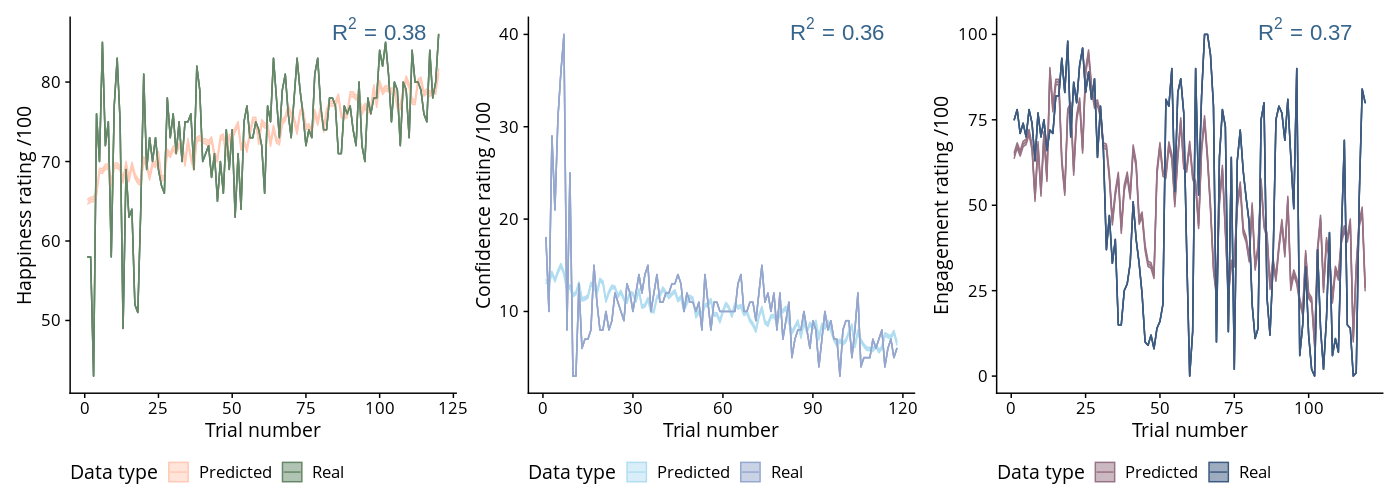

In [23]:
%%R -w 14 -h 5 --units in -r 100
plts_nd <- pstpipeline::plot_affect(
    fits$nd, plt_type = "individual", pal = pal, font = "Open Sans", 
    font_size = 14, legend_pos = "bottom", r2_coords = c(0.8, 0.97)
)
plts_nd$happy + plts_nd$confident + plts_nd$engaged

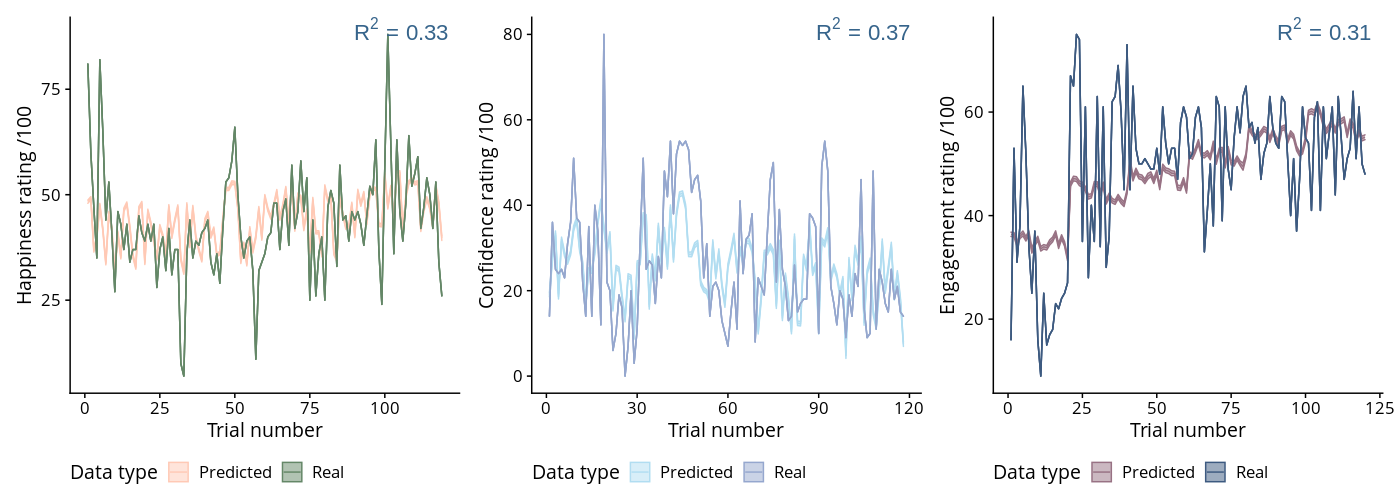

In [24]:
%%R -w 14 -h 5 --units in -r 100
plts_dis <- pstpipeline::plot_affect(
    fits$dis, plt_type = "individual", pal = pal, font = "Open Sans", 
    font_size = 14, legend_pos = "bottom", r2_coords = c(0.85, 0.97)
)
plts_dis$happy + plts_dis$confident + plts_dis$engaged

### Get parameter values and plot weights

In [25]:
%%R
pars_nd  <- pstpipeline::make_par_df(raw_df_nd, summary_df_nd)
pars_dis <- pstpipeline::make_par_df(raw_df_dis, summary_df_dis)

pars_all <- 
    dplyr::bind_rows(
        dplyr::mutate(pars_nd, grp = "Non-distanced"),
        dplyr::mutate(pars_dis, grp = "Distanced")
    ) |>
    dplyr::group_by(parameter, adj, grp) |> 
    dplyr::summarise(
        n = dplyr::n(), 
        median = median(posterior_mean, na.rm = TRUE), 
        mean = mean(posterior_mean, na.rm = TRUE),
        sd = sd(posterior_mean),
        min = min(posterior_mean, na.rm = TRUE),
        max = max(posterior_mean, na.rm = TRUE),
        .groups = "keep"
    )
print(pars_all, n = 42)

# A tibble: 40 × 9
# Groups:   parameter, adj, grp [40]
   parameter adj       grp               n  median    mean     sd       min   max
   <chr>     <chr>     <chr>         <int>   <dbl>   <dbl>  <dbl>     <dbl> <dbl>
 1 alpha     <NA>      Distanced       459  0.0271  0.0785 0.0959  0.00140  0.396
 2 alpha     <NA>      Non-distanced   476  0.0208  0.0691 0.0962  0.00146  0.633
 3 beta      <NA>      Distanced       459  2.14    2.95   2.23    0.0874   9.43 
 4 beta      <NA>      Non-distanced   476  2.07    2.71   2.05    0.111    9.34 
 5 gamma     confident Distanced       459  0.330   0.345  0.135   0.0229   0.891
 6 gamma     confident Non-distanced   476  0.345   0.355  0.141   0.0455   0.827
 7 gamma     engaged   Distanced       459  0.324   0.338  0.145   0.0236   0.876
 8 gamma     engaged   Non-distanced   476  0.331   0.346  0.136   0.00720  0.851
 9 gamma     happy     Distanced       459  0.326   0.346  0.146   0.0395   0.849
10 gamma     happy     Non-distanced   476

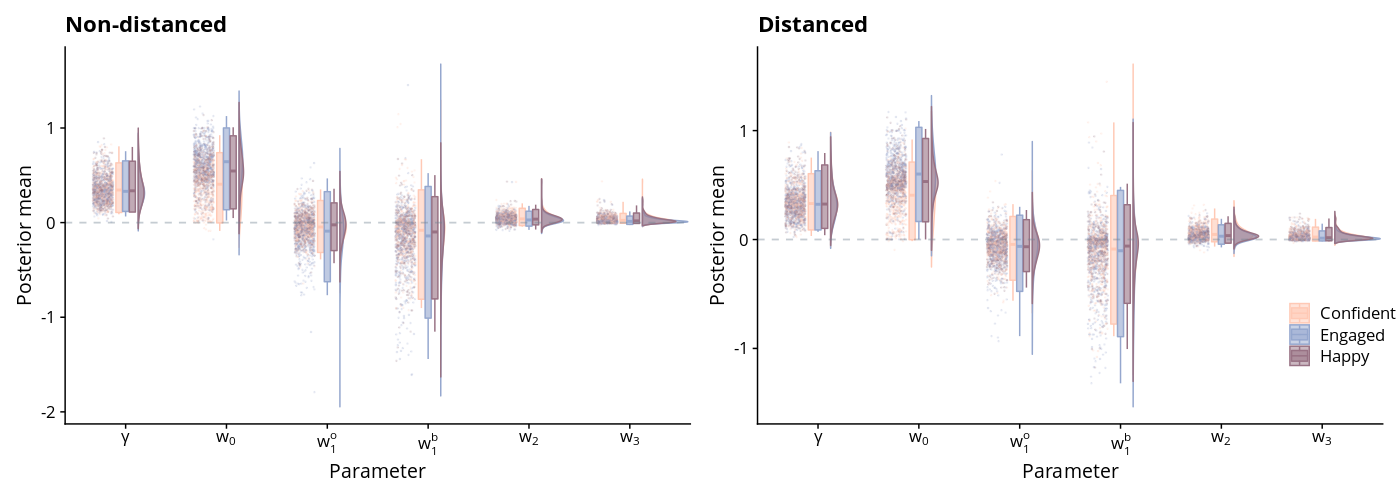

In [26]:
%%R -w 14 -h 5 --units in -r 100
wt_nd <- 
    pstpipeline::plot_affect(
        pars_nd, plt_type = "weights", pal = pal_contr, font = "Open Sans", 
        font_size = 14, legend_pos = "none"
    ) +
    ggplot2::ggtitle("Non-distanced")
    
wt_dis <- 
    pstpipeline::plot_affect(
        pars_dis, plt_type = "weights", pal = pal_contr, font = "Open Sans", 
        font_size = 14, legend_pos = c(0.85, 0.25)
    ) +
    ggplot2::ggtitle("Distanced")

wt_nd + wt_dis

Though we can see quite clearly the trends across both groups in baseline ratings ($w_0$), with engagement having the highest baseline rating, and confidence the lowest, it seems there are limited obvious between-group differences (explored further below).

## Parameter recovery

In all cases, data is simulated directly from fitted parameter values, though using a newly randomised set of trials. This is becuase to an extent it is clear the parameters are closely related - simulating a random set of weights and $Q$-learning parameters from approximate distributions resulted in dropped evaluations and failures to fit. This is partly because, by definition, ADVI aims to find an approximate posterior distribution which is multivariate Gaussian in the unconstrained variable space. As such, recovered parameters will be susceptible to biases and intercorrelations found in the original parameter estimates.

### Original model

In [27]:
%%R
# dir.create(file.path("outputs/cmdstan/affect_1a/simulated_data"))
summary_df_3wt <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m1/fit_pst_training_1a_vb_summary.RDS")
raw_df_3wt <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m1/fit_pst_training_1a_vb_raw_df.RDS")

affect_3wt_sim <- pstpipeline::simulate_QL(
    summary_df = summary_df_3wt,
    sample_size = 250,
    affect = TRUE,
    gain_loss = FALSE,
    raw_df = raw_df_3wt
)
saveRDS(affect_3wt_sim, "outputs/cmdstan/affect_1a/simulated_data/affect_3wt_sim.RDS")

  |==============================================================================================================| 100%

In [28]:
%%R
vb_affect_3wt_sim <- pstpipeline::fit_learning_model(
    affect_3wt_sim$sim, model = "1a", exp_part = "training", 
    par_recovery = TRUE, affect = TRUE, affect_sfx = "3wt", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_1a/simulated_data/3wt"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\| 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 1.07228 seconds 
1000 transitions using 10 leapfrog steps per transition would take 10722.8 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Success! Found best value [eta = 1] earlier than expected. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100        -3256.353             1.000            1.000 
   200        50698.35

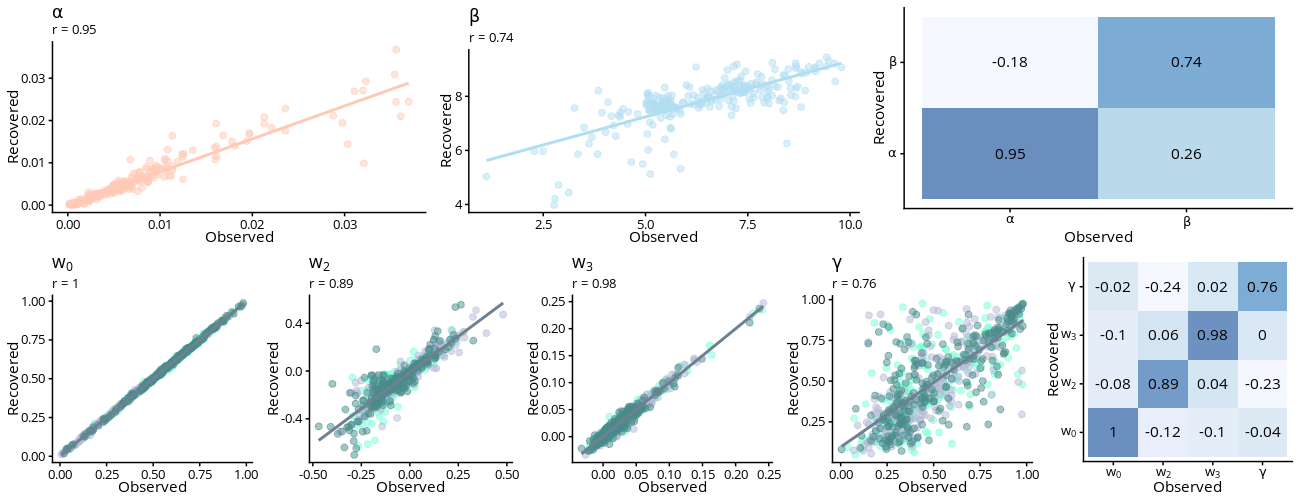

In [29]:
%%R -w 13 -h 5 --units in -r 100
recovery_plots <- list()

affect_3wt_sim <- readRDS(
    "outputs/cmdstan/affect_1a/simulated_data/affect_3wt_sim.RDS"
)
affect_3wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_1a/simulated_data/3wt/fit_pst_training_1a_vb_summary.RDS"
)

recovery_plots$affect_3wt <- pstpipeline::plot_recovery(
    affect_3wt_sim$pars, affect_3wt_sim_fitted, affect = TRUE, pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_3wt

### 'Passage-of-time' model

In [30]:
%%R
summary_df_4wt <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m4/fit_pst_training_1a_vb_summary.RDS")
raw_df_4wt <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m4/fit_pst_training_1a_vb_raw_df.RDS")

affect_4wt_sim <- pstpipeline::simulate_QL(
    summary_df = summary_df_4wt,
    sample_size = 250,
    affect = TRUE,
    gain_loss = FALSE,
    raw_df = raw_df_4wt
)
saveRDS(affect_4wt_sim, "outputs/cmdstan/affect_1a/simulated_data/affect_4wt_sim.RDS")

  |==============================================================================================================| 100%

In [31]:
%%R
vb_affect_4wt_sim <- pstpipeline::fit_learning_model(
    affect_4wt_sim$sim, model = "1a", exp_part = "training", 
    par_recovery = TRUE, affect = TRUE, affect_sfx = "4wt_time", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_1a/simulated_data/4wt"
)

R[write to console]: Compiling Stan program...



-------------------------------------------------------------\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 1.02137 seconds 
1000 transitions using 10 leapfrog steps per transition would take 10213.7 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -238254.554             1.000            1.000 


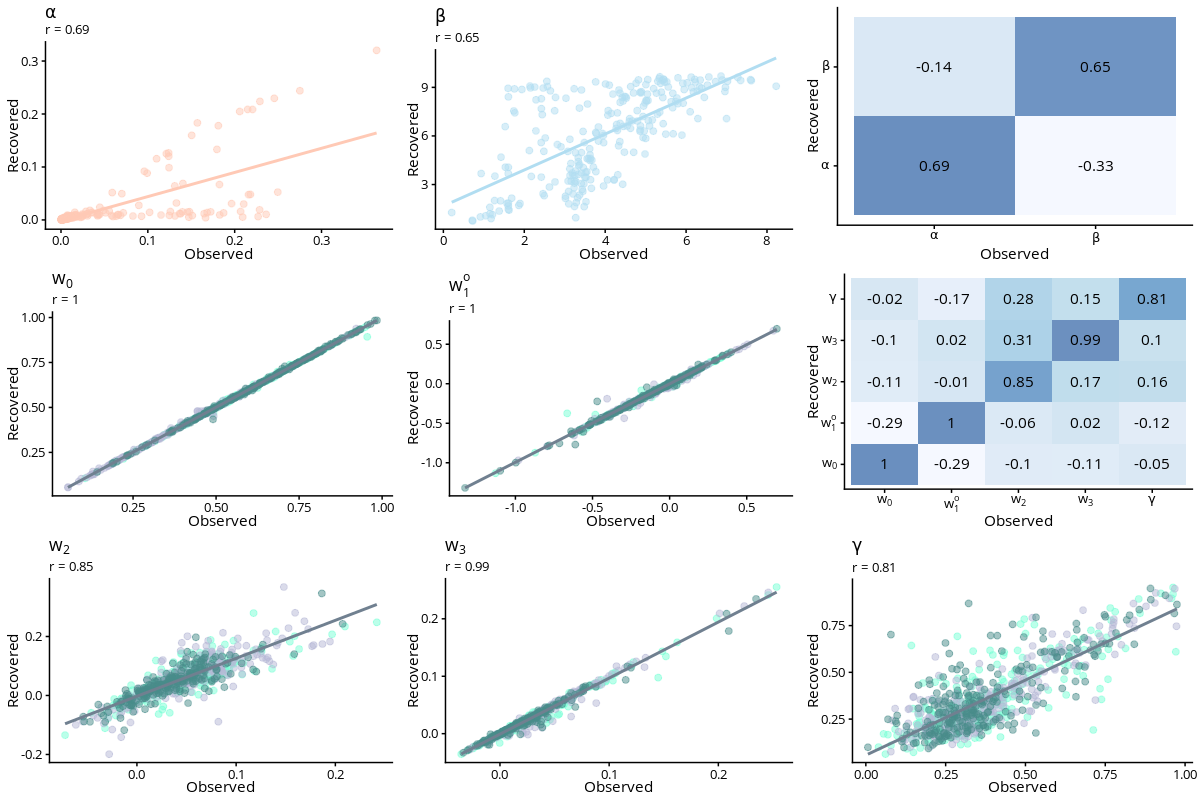

In [32]:
%%R -w 12 -h 8 --units in -r 100
affect_4wt_sim <- readRDS(
    "outputs/cmdstan/affect_1a/simulated_data/affect_4wt_sim.RDS"
)
affect_4wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_1a/simulated_data/4wt/fit_pst_training_1a_vb_summary.RDS"
)

recovery_plots$affect_4wt_time <- pstpipeline::plot_recovery(
    affect_4wt_sim$pars, affect_4wt_sim_fitted, affect = TRUE, pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_4wt_time

### 'Passage-of-time' model plus block-wise time

In [33]:
%%R
summary_df_5wt <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_summary.RDS")
raw_df_5wt <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_raw_df.RDS")

affect_5wt_sim <- pstpipeline::simulate_QL(
    summary_df = summary_df_5wt,
    sample_size = 250,
    affect = TRUE,
    gain_loss = FALSE,
    raw_df = raw_df_5wt
)
saveRDS(affect_5wt_sim, "outputs/cmdstan/affect_1a/simulated_data/affect_5wt_sim.RDS")

  |==============================================================================================================| 100%

In [34]:
%%R
vb_affect_5wt_sim <- pstpipeline::fit_learning_model(
    affect_5wt_sim$sim, model = "1a", exp_part = "training", 
    par_recovery = TRUE, affect = TRUE, affect_sfx = "5wt_time", 
    vb = TRUE, ppc = TRUE, model_checks = FALSE, 
    outputs = c("raw_df", "stan_datalist", "summary", "draws_list"),
    out_dir = "outputs/cmdstan/affect_1a/simulated_data/5wt"
)

R[write to console]: Model executable is up to date!



------------------------------------------------------------ 
EXPERIMENTAL ALGORITHM: 
  This procedure has not been thoroughly tested and may be unstable 
  or buggy. The interface is subject to change. 
------------------------------------------------------------ 
Gradient evaluation took 0.970705 seconds 
1000 transitions using 10 leapfrog steps per transition would take 9707.05 seconds. 
Adjust your expectations accordingly! 
Begin eta adaptation. 
Iteration:   1 / 250 [  0%]  (Adaptation) 
Iteration:  50 / 250 [ 20%]  (Adaptation) 
Iteration: 100 / 250 [ 40%]  (Adaptation) 
Iteration: 150 / 250 [ 60%]  (Adaptation) 
Iteration: 200 / 250 [ 80%]  (Adaptation) 
Iteration: 250 / 250 [100%]  (Adaptation) 
Success! Found best value [eta = 0.1]. 
Begin stochastic gradient ascent. 
  iter             ELBO   delta_ELBO_mean   delta_ELBO_med   notes  
   100      -425686.532             1.000            1.000 
   200      -217110.795             0.980            1.000 
   300      -173487.0

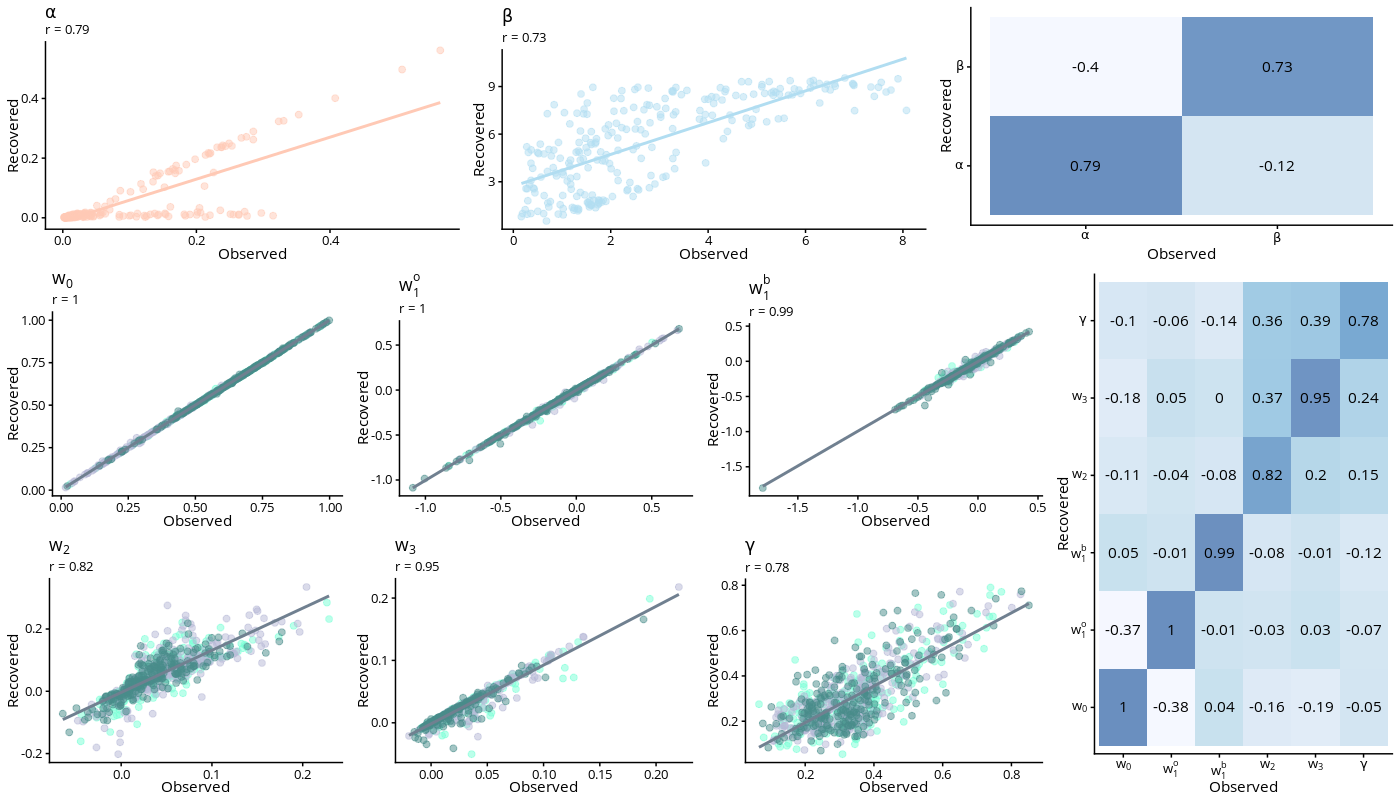

In [35]:
%%R -w 14 -h 8 --units in -r 100
affect_5wt_sim <- readRDS(
    "outputs/cmdstan/affect_1a/simulated_data/affect_5wt_sim.RDS"
)
affect_5wt_sim_fitted <- readRDS(
    "outputs/cmdstan/affect_1a/simulated_data/5wt/fit_pst_training_1a_vb_summary.RDS"
)

recovery_plots$affect_5wt_time <- pstpipeline::plot_recovery(
    affect_5wt_sim$pars, affect_5wt_sim_fitted, affect = TRUE, pal = pal_recovery, font = "Open Sans"
)
recovery_plots$affect_5wt_time

In all models, it appears that the weights, and to a lesser extent the decay factor $\gamma$, are well-recovered by all three models investigated here, with relatively low confusability (except, perhaps unsurprisingly, $w_2$ and $w_3$). However, the $Q$-learning parameters were not as well-recovered.

## Associations between model parameters and transdiagnostic mental health

First, we take a look at the raw correlations between baseline affect ($w_0$) and each of the three transdiagnostic mental health dimensions of interest - anxiety/depression, compulsive behaviour, and social withdrawal (see the "data_cleaning_factor_derivation" notebook for more information on these).

In [36]:
%%R
summary_df_5wt_nd <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_summary.RDS")
raw_df_5wt_nd <- readRDS("outputs/cmdstan/affect_1a/non-distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_raw_df.RDS")
summary_df_5wt_dis <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_summary.RDS")
raw_df_5wt_dis <- readRDS("outputs/cmdstan/affect_1a/distanced/model_fits/model_comp/m5/fit_pst_training_1a_vb_raw_df.RDS")
factor_scores <- read.csv("/group/cemhp/E3_Data/online_decision_making/package_outputs_dec_2021/outputs/factor_prediction/all_935_predicted_factor_scores.csv")[-1]

all_pars_5wt <- dplyr::bind_rows(
  pstpipeline::make_par_df(raw_df_5wt_nd, summary_df_5wt_nd),
  pstpipeline::make_par_df(raw_df_5wt_dis, summary_df_5wt_dis)
)

cor_test <- function(df, adj, factor) {
  tst <- cor.test(df[df$adj == adj,]$posterior_mean, df[df$adj == adj,][[factor]])
  tibble::tibble(
    "factor" = factor,
    "adj" = adj,
    "est" = tst$estimate[1], 
    "conf_int" = paste0(
      "(", round(tst$conf.int[1], 3), ", ",  round(tst$conf.int[2], 3), ")"
    ), 
    "p_value" = ifelse(
      tst$p.value[1] < 0.0001, "<0.0001", 
      format(round(tst$p.value[1], digits = 4), nsmall = 4, scientific = FALSE))
    )
}

w0_factors_df <- dplyr::filter(
  dplyr::left_join(all_pars_5wt, factor_scores, by = "subjID"), parameter == "w0"
)

dplyr::bind_rows(
  cor_test(w0_factors_df, "happy", "AD"),
  cor_test(w0_factors_df, "happy", "Compul"),
  cor_test(w0_factors_df, "happy", "SW"),
  cor_test(w0_factors_df, "confident", "AD"),
  cor_test(w0_factors_df, "confident", "Compul"),
  cor_test(w0_factors_df, "confident", "SW"),
  cor_test(w0_factors_df, "engaged", "AD"),
  cor_test(w0_factors_df, "engaged", "Compul"),
  cor_test(w0_factors_df, "engaged", "SW"),
)

# A tibble: 9 × 5
  factor adj           est conf_int         p_value
  <chr>  <chr>       <dbl> <chr>            <chr>  
1 AD     happy     -0.245  (-0.305, -0.184) <0.0001
2 Compul happy     -0.0991 (-0.162, -0.035) 0.0024 
3 SW     happy     -0.119  (-0.182, -0.055) 0.0003 
4 AD     confident -0.165  (-0.227, -0.102) <0.0001
5 Compul confident -0.0189 (-0.083, 0.045)  0.5647 
6 SW     confident -0.119  (-0.182, -0.056) 0.0003 
7 AD     engaged   -0.146  (-0.208, -0.082) <0.0001
8 Compul engaged   -0.0972 (-0.16, -0.033)  0.0029 
9 SW     engaged   -0.0605 (-0.124, 0.004)  0.0643 


Notably, there appears to be strong evidence of a moderate negative correlation between high anxiety/depression scores, and baseline happiness, confidence, and engagement. In addition there is a weaker evidence of negative associations between compulsive behaviour scores and baseline happinesss and engagement, as well as social withdrawal with happiness and confidence.

To investigate this further, we use Bayesian generalised linear models (GLMs), adjusted for age, sex, digit span, and distancing group. The response distribution was assumed to be Gaussian for all weight parameters plus inverse temperatures ($\beta$), and Gamma for learning rates ($\alpha$) and the decay factor ($\gamma$). We primarily focus on the affect-related parameters here given these potential issues with the $Q$-learning parameters.

### Association between anxiety/depression scores and affect model parameters

In [37]:
%%R
AD_affect <- list()

AD_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.
Chain 2 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.
Chain 3 finished in 1.8 seconds.
Chain 2 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.9 seconds.
Chain 1 finished in 7.1 seconds.
Chain 4 finished in 7.1 seconds.
Chain 3 finished in 7.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.1 seconds.
Total execution time: 7.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.4 seconds.
Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.
Chain 2 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 3 finished in 1.8 seconds.
Chain 2 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 2 finished in 7.1 seconds.
Chain 3 finished in 7.0 seconds.
Chain 4 finished in 7.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.0 seconds.
Total execution time: 7.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.5 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 3 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 4 finished in 7.2 seconds.
Chain 3 finished in 7.9 seconds.
Chain 2 finished in 9.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.8 seconds.
Total execution time: 9.2 seconds.


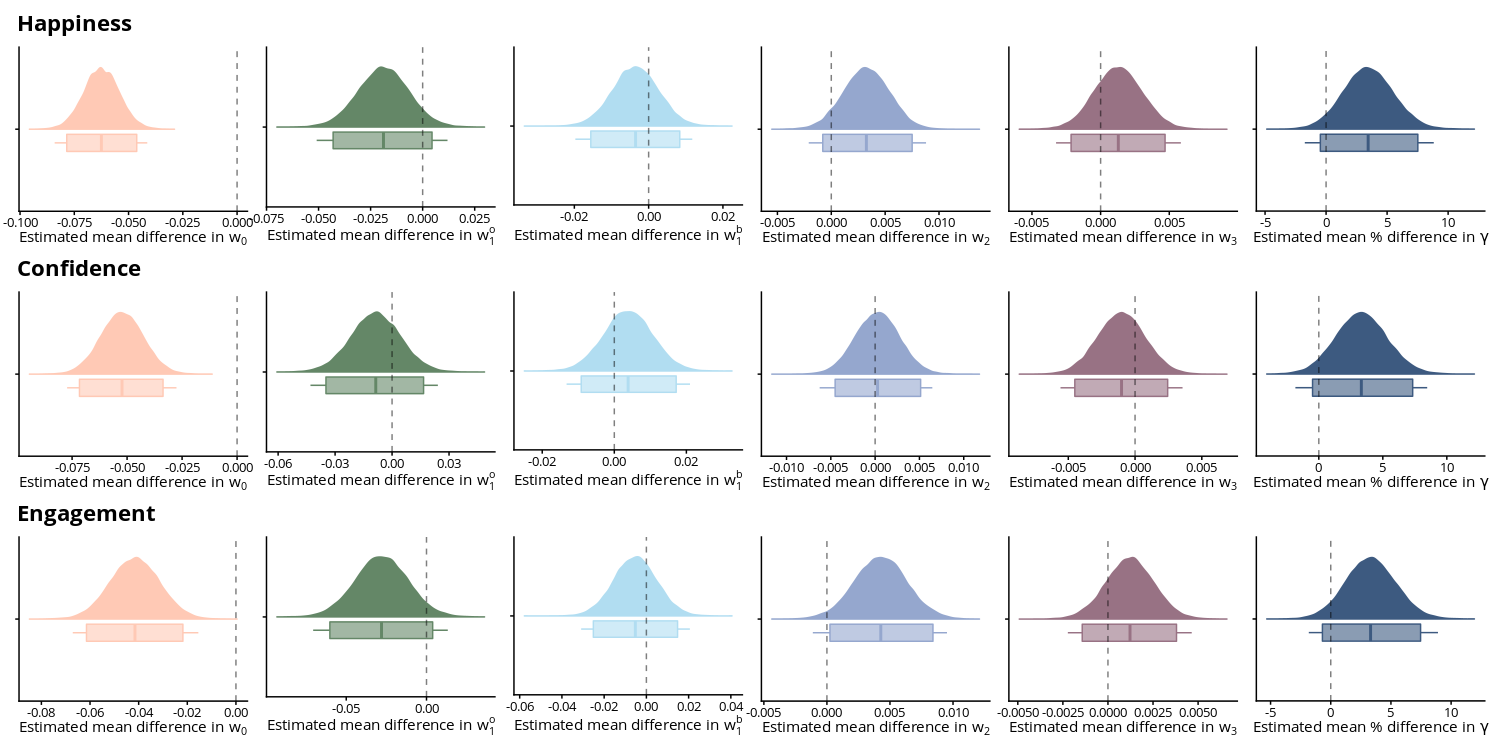

In [38]:
%%R -w 15 -h 7.5 --units in -r 100
# library(patchwork)

AD_plt_happy <- pstpipeline::plot_glm(
  AD_affect$happy, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_plt_conf <- pstpipeline::plot_glm(
  AD_affect$confident, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_plt_bored <- pstpipeline::plot_glm(
  AD_affect$engaged, plot_var = "AD", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_plt_happy / AD_plt_conf / AD_plt_bored

Here we again see clear evidence that higher anxiety/depression scores are associated with lower baseline affect ratings, after controlling for age, sex, digit span, and distancing group. However, there is little evidence of an association between anxiety/depression scores and any other model parameter. This suggests that those with higher anxiety/depression scores incorporate slightly more trials in their calculation of the delay discounted effects of expected value and prediction error. In addition, on average, those with higher anxiety/depression scores appear to decay more in happiness and engagement (i.e., lower $w^o_1$), which is opposite to an observation previously noted by [Jangraw *et al.,* 2022](https://psyarxiv.com/bwv58) in their paper on "passage-of-time" dysphoria, though in our case the evidence for this is very weak.

### Association between compulsive behaviour factor scores and model parameters

In [39]:
%%R
CB_affect <- list()

CB_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

CB_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

CB_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "Compul",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.8 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.6 seconds.
Chain 2 finished in 1.8 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.2 seconds.
Chain 3 finished in 7.2 seconds.
Chain 2 finished in 7.4 seconds.
Chain 4 finished in 7.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 7.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.
Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.1 seconds.
Chain 2 finished in 7.2 seconds.
Chain 3 finished in 7.6 seconds.
Chain 4 finished in 9.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.8 seconds.
Total execution time: 9.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.5 seconds.
Chain 1 finished in 1.7 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 1.5 seconds.
Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.7 seconds.
Chain 2 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 7.0 seconds.
Chain 1 finished in 7.3 seconds.
Chain 3 finished in 7.4 seconds.
Chain 2 finished in 7.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 7.7 seconds.


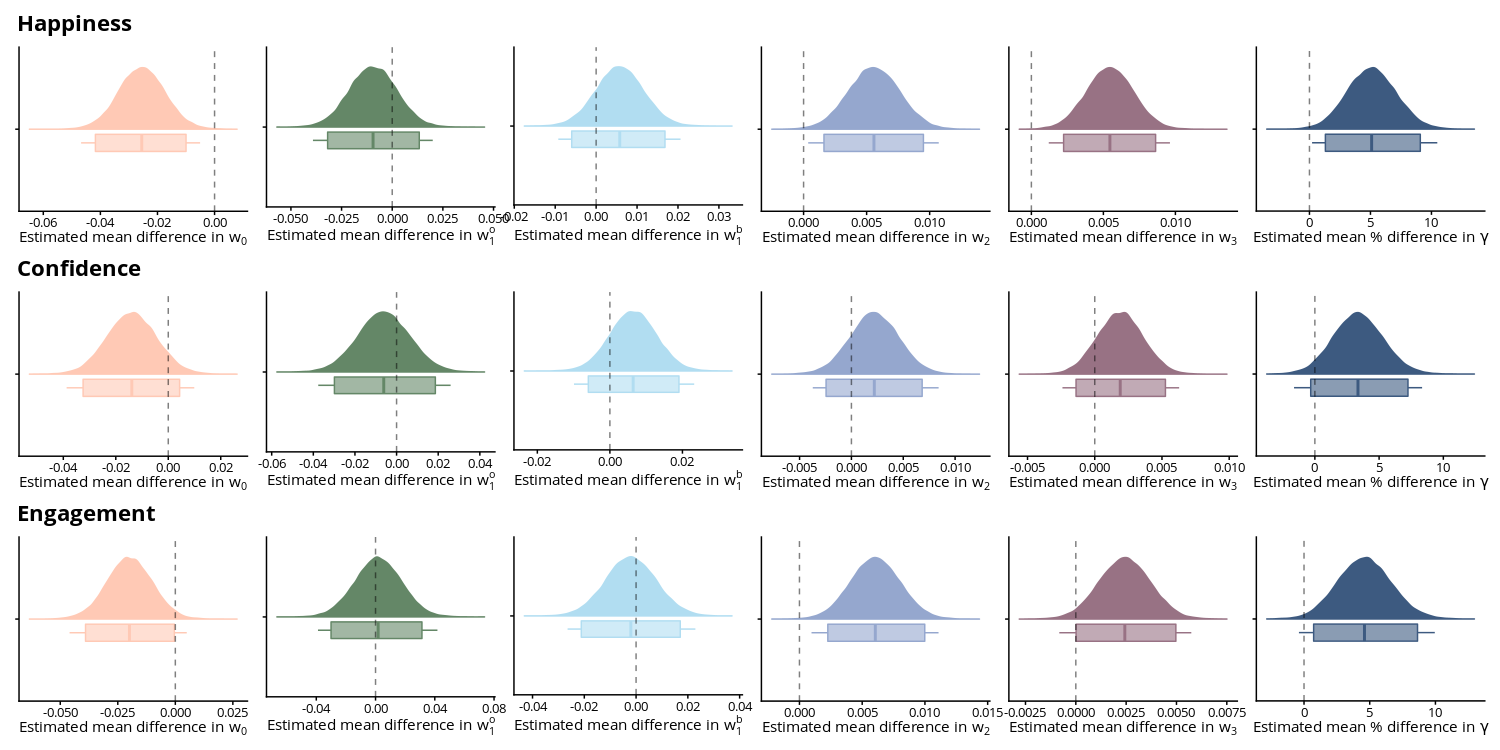

In [40]:
%%R -w 15 -h 7.5 --units in -r 100

CB_plt_happy <- pstpipeline::plot_glm(
  CB_affect$happy, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
CB_plt_conf <- pstpipeline::plot_glm(
  CB_affect$confident, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
CB_plt_bored <- pstpipeline::plot_glm(
  CB_affect$engaged, plot_var = "Compul", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

CB_plt_happy / CB_plt_conf / CB_plt_bored

Interestingly, it appears that higher compusive behaviour factor scores are not associated with any differences in confidence model parameters. However, there is evidence that, like anxiety/depression, higher compulsive behaviour factor scores are asssociated with lower baseline happiness and (to a small extent) engagement ($w_0$). In addition, those with higher compulsive behaviour scores have higher values for $w_2$ and $w_3$ for happiness and engagment, or weights on Q-learning model expected values and prediction errors, plus higher discount factors ($\gamma$), interestingly suggesting they incorporate more trials in the fluctuation of their subjective affect judgements. What this may ultimately translate to is increased fluctuations in score following wins and losses.

### Association between social withdrawal factor scores and model parameters

In [41]:
%%R
SW_affect <- list()

SW_affect$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

SW_affect$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

SW_affect$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "SW",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.
Chain 2 finished in 1.9 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.9 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 6.9 seconds.
Chain 2 finished in 7.1 seconds.
Chain 4 finished in 7.1 seconds.
Chain 1 finished in 7.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.1 seconds.
Total execution time: 7.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 3 finished in 7.1 seconds.
Chain 4 finished in 7.3 seconds.
Chain 2 finished in 7.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 7.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.8 seconds.
Chain 1 finished in 1.9 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 1.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.1 seconds.
Chain 4 finished in 6.9 seconds.
Chain 2 finished in 7.1 seconds.
Chain 3 finished in 8.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 8.3 seconds.


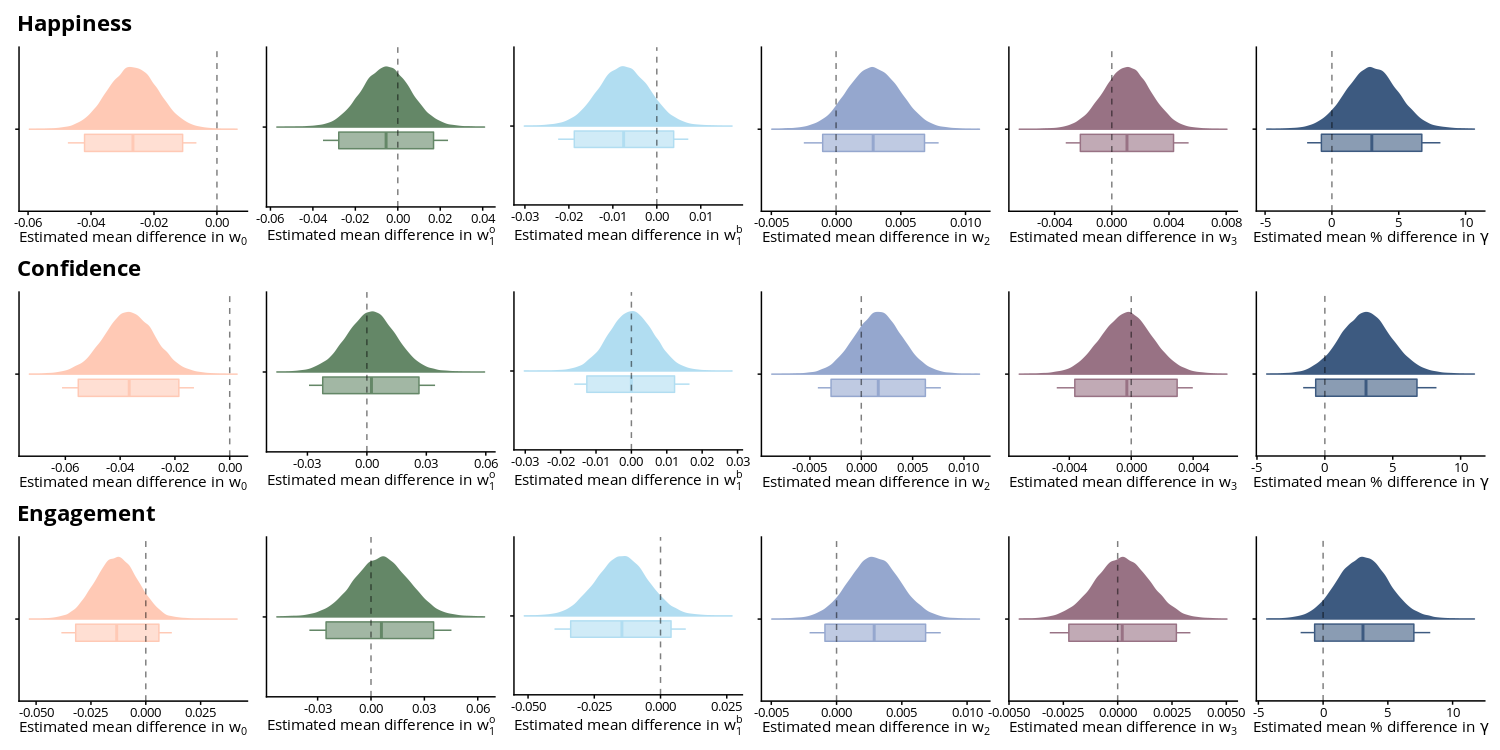

In [42]:
%%R -w 15 -h 7.5 --units in -r 100

SW_plt_happy <- pstpipeline::plot_glm(
  SW_affect$happy, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
SW_plt_conf <- pstpipeline::plot_glm(
  SW_affect$confident, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
SW_plt_bored <- pstpipeline::plot_glm(
  SW_affect$engaged, plot_var = "SW", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

SW_plt_happy / SW_plt_conf / SW_plt_bored

Lastly, for social withdrawal factor scores, higher scores are associated again with lower baseline happiness, as well as lower baseline confidence, but not lower baseline engagement. There is limited evidence of any association with any other model parameters, however.

In [43]:
%%R
transdiag_aff_mods <- list()
transdiag_aff_mods$AD <- AD_affect
transdiag_aff_mods$CB <- CB_affect
transdiag_aff_mods$SW <- SW_affect

dir.create("outputs/cmdstan/affect_1a/outcome_glms")
saveRDS(transdiag_aff_mods, "outputs/cmdstan/affect_1a/outcome_glms/transdiag_affect_models.RDS")

## Associations between model parameters and cognitive distancing

First, we take a look to see whether we can replicate our previous findings - that cognitive distancing is associated with higher inverse temperatures ($\beta$) and late-stage increases in negative learning rates ($\alpha_{loss}$) during the probabilistic selection task.

In [44]:
%%R
dist_QL_affect <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.4 seconds.
Chain 4 finished in 6.4 seconds.
Chain 3 finished in 6.6 seconds.
Chain 1 finished in 6.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 6.5 seconds.
Total execution time: 7.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


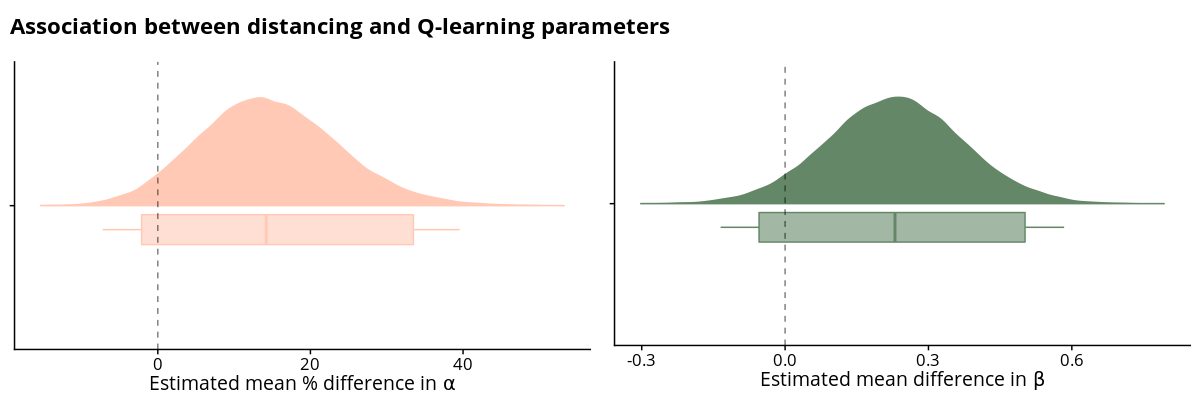

In [45]:
%%R -w 12 -h 4 --units in -r 100

dist_plt_QL <- pstpipeline::plot_glm(
  dist_QL_affect, plot_var = "distanced", alpha_par_nms = c("reward", "loss"), 
  font = "Open Sans", font_size = 14, pal = pal, 
  ovrll_title = "Association between distancing and Q-learning parameters"
)
dist_plt_QL

Interestingly, we replicate our finding that the distanced group appear to have higher learning rates and inverse temperatures by the end of training, albeit not with as strong evidence as results with MCMC.

In [46]:
%%R
dist_models <- list()

dist_models$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  iter_warmup = 2000, iter_sampling = 10000
)

dist_models$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  iter_warmup = 2000, iter_sampling = 10000
)

dist_models$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "distanced",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 1 finished in 1.7 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.9 seconds.
Chain 3 finished in 6.9 seconds.
Chain 4 finished in 6.9 seconds.
Chain 1 finished in 7.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.0 seconds.
Total execution time: 7.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.3 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.
Chain 2 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 6.7 seconds.
Chain 2 finished in 6.7 seconds.
Chain 3 finished in 6.7 seconds.
Chain 4 finished in 7.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 6.8 seconds.
Total execution time: 7.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.3 seconds.
Chain 2 finished in 1.3 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.3 seconds.
Chain 2 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.6 seconds.
Chain 1 finished in 1.8 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.7 seconds.
Chain 3 finished in 6.8 seconds.
Chain 4 finished in 7.0 seconds.
Chain 1 finished in 7.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 6.9 seconds.
Total execution time: 7.4 seconds.


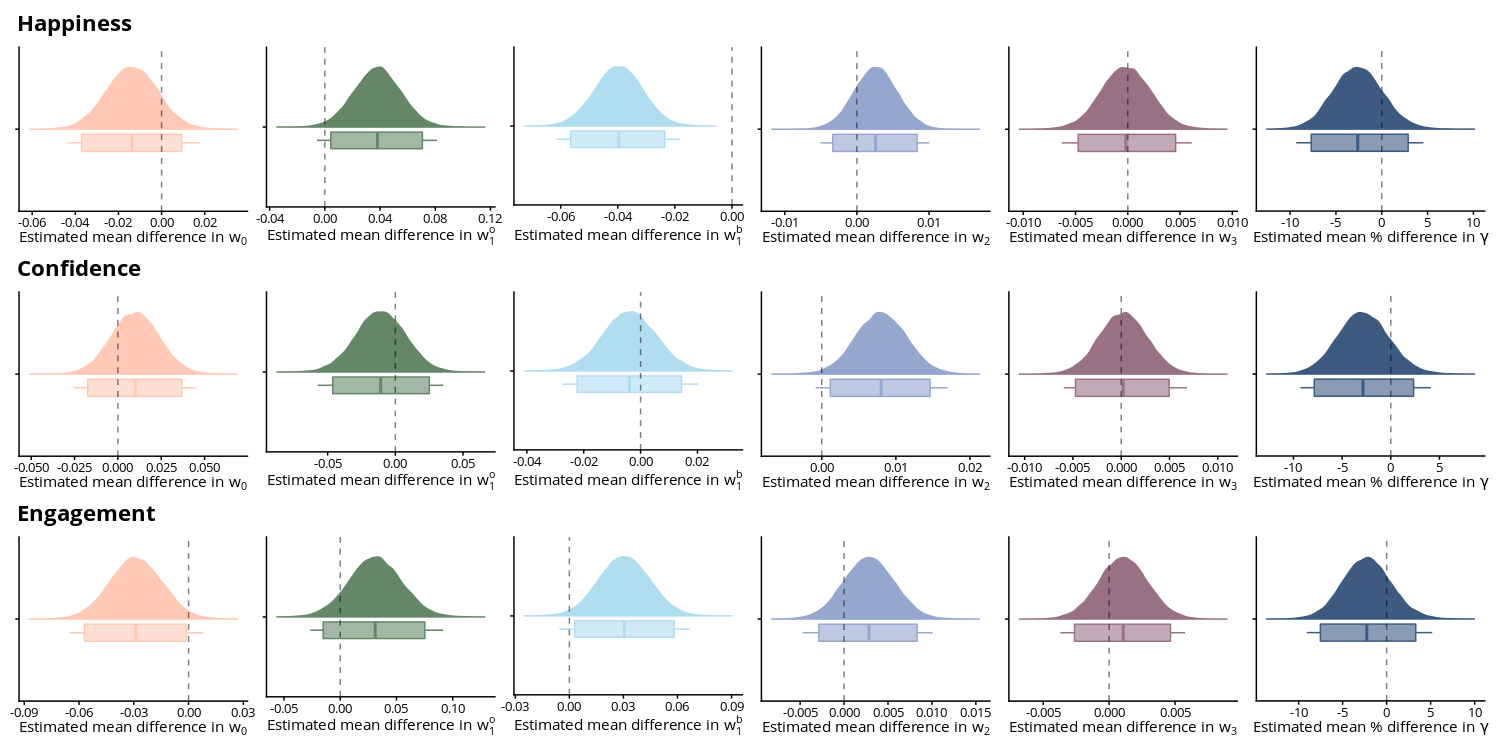

In [47]:
%%R -w 15 -h 7.5 --units in -r 100

dist_plt_happy <- pstpipeline::plot_glm(
  dist_models$happy, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
dist_plt_conf <- pstpipeline::plot_glm(
  dist_models$confident, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
dist_plt_bored <- pstpipeline::plot_glm(
  dist_models$engaged, plot_var = "distanced", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

dist_plt_happy / dist_plt_conf / dist_plt_bored

These results indicate that participants in the distancing group differed in a number of ways across the three adjectives. Distanced individuals decayed less across the task in terms of happiness (higher $w^o_1$), and remained *more* engaged throughout the blocks (higher $w^b_1$). These results broadly replicate those from simple analyses found in our [earlier preprint](https://psyarxiv.com/jmnek), where we found in multilevel models with a random intercept for participant ID that distanced participants decreased less in happiness and engagement, but not confidence, over the course of the task. 

That said, distanced individuals also had slightly lower baseline engagement, and became *less* happy thoughout those same blocks (lower $w^b_1$). Notably, [previous work](https://psyarxiv.com/bwv58) has suggested that decay of happiness ratings may be related to boredom &mdash; though there is some very weak evidence that distanced individuals remained more engaged over the whole task (on average slightly higher $w^o_1$) in a similar manner to happiness, it is perhaps interesting that there is a dissociation between blockwise time decay in happiness and engagement, suggesting they are not entirely the same.

In [48]:
%%R
saveRDS(dist_models, "outputs/cmdstan/affect_1a/outcome_glms/distancing_affect_models.RDS")

## Exploratory analysis 1: Do associations between anxiety/depression scores and model parameters differ by 'treatment' group?

Though we did have a primary "treatment" group - participants who engaged in cognitive distancing - we also asked individuals about medication usage, and a fairly large number reported being on an antidepressant (n=130 of the 935 non-excluded individuals (13.9\%); 69 distanced). This allows us to compare the effect of a psychological treatment (cognitive distancing) and a pharmacological treatment (antidepressants).

### Cognitive distancing

In [49]:
%%R
AD_dist_int <- list()

AD_dist_int$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 1,
  interaction = "distanced", 
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_dist_int$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 2,
  interaction = "distanced",
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_dist_int$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span"),
  affect_number = 3,
  interaction = "distanced", 
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 1 finished in 2.7 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.4 seconds.
Chain 1 finished in 2.7 seconds.
Chain 3 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.3 seconds.
Chain 3 finished in 2.4 seconds.
Chain 4 finished in 2.4 seconds.
Chain 2 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.4 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 3 finished in 2.5 seconds.
Chain 1 finished in 2.8 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 3 finished in 2.6 seconds.
Chain 2 finished in 2.8 seconds.
Chain 4 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 19.5 seconds.
Chain 4 finished in 19.4 seconds.
Chain 3 finished in 19.8 seconds.
Chain 1 finished in 20.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 19.8 seconds.
Total execution time: 20.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.6 seconds.
Chain 4 finished in 2.4 seconds.
Chain 3 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.3 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.2 seconds.
Chain 1 finished in 2.5 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 1 finished in 2.8 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.8 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 16.7 seconds.
Chain 2 finished in 18.9 seconds.
Chain 4 finished in 18.8 seconds.
Chain 3 finished in 19.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 18.4 seconds.
Total execution time: 19.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.4 seconds.
Chain 3 finished in 2.4 seconds.
Chain 4 finished in 2.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.4 seconds.
Total execution time: 2.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 1 finished in 2.8 seconds.
Chain 4 finished in 2.7 seconds.
Chain 3 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.5 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.4 seconds.
Chain 1 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 14.9 seconds.
Chain 1 finished in 16.6 seconds.
Chain 2 finished in 17.4 seconds.
Chain 3 finished in 18.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 16.8 seconds.
Total execution time: 18.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.
Chain 4 finished in 2.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 2.3 seconds.
Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.6 seconds.
Chain 1 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 2.3 seconds.
Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 3 finished in 2.3 seconds.
Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.4 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.5 seconds.
Chain 2 finished in 2.4 seconds.
Chain 4 finished in 2.4 seconds.
Chain 3 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 14.5 seconds.
Chain 1 finished in 17.2 seconds.
Chain 2 finished in 18.5 seconds.
Chain 3 finished in 19.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 17.4 seconds.
Total execution time: 19.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 1 finished in 2.7 seconds.
Chain 4 finished in 2.6 seconds.
Chain 3 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.5 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.7 seconds.
Chain 4 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 4 finished in 2.3 seconds.
Chain 3 finished in 2.5 seconds.
Chain 1 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 3.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 16.4 seconds.
Chain 2 finished in 16.9 seconds.
Chain 3 finished in 17.5 seconds.
Chain 1 finished in 18.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 17.4 seconds.
Total execution time: 18.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.5 seconds.
Chain 1 finished in 2.6 seconds.
Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.5 seconds.
Total execution time: 2.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.6 seconds.
Chain 3 finished in 2.7 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.7 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.3 seconds.
Chain 2 finished in 2.6 seconds.
Chain 4 finished in 2.5 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.6 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.4 seconds.
Chain 2 finished in 2.3 seconds.
Chain 3 finished in 2.2 seconds.
Chain 4 finished in 2.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.4 seconds.
Total execution time: 3.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.3 seconds.
Chain 1 finished in 2.5 seconds.
Chain 3 finished in 2.4 seconds.
Chain 4 finished in 2.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.4 seconds.
Total execution time: 2.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 17.0 seconds.
Chain 4 finished in 18.7 seconds.
Chain 3 finished in 18.9 seconds.
Chain 1 finished in 19.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 18.4 seconds.
Total execution time: 19.3 seconds.


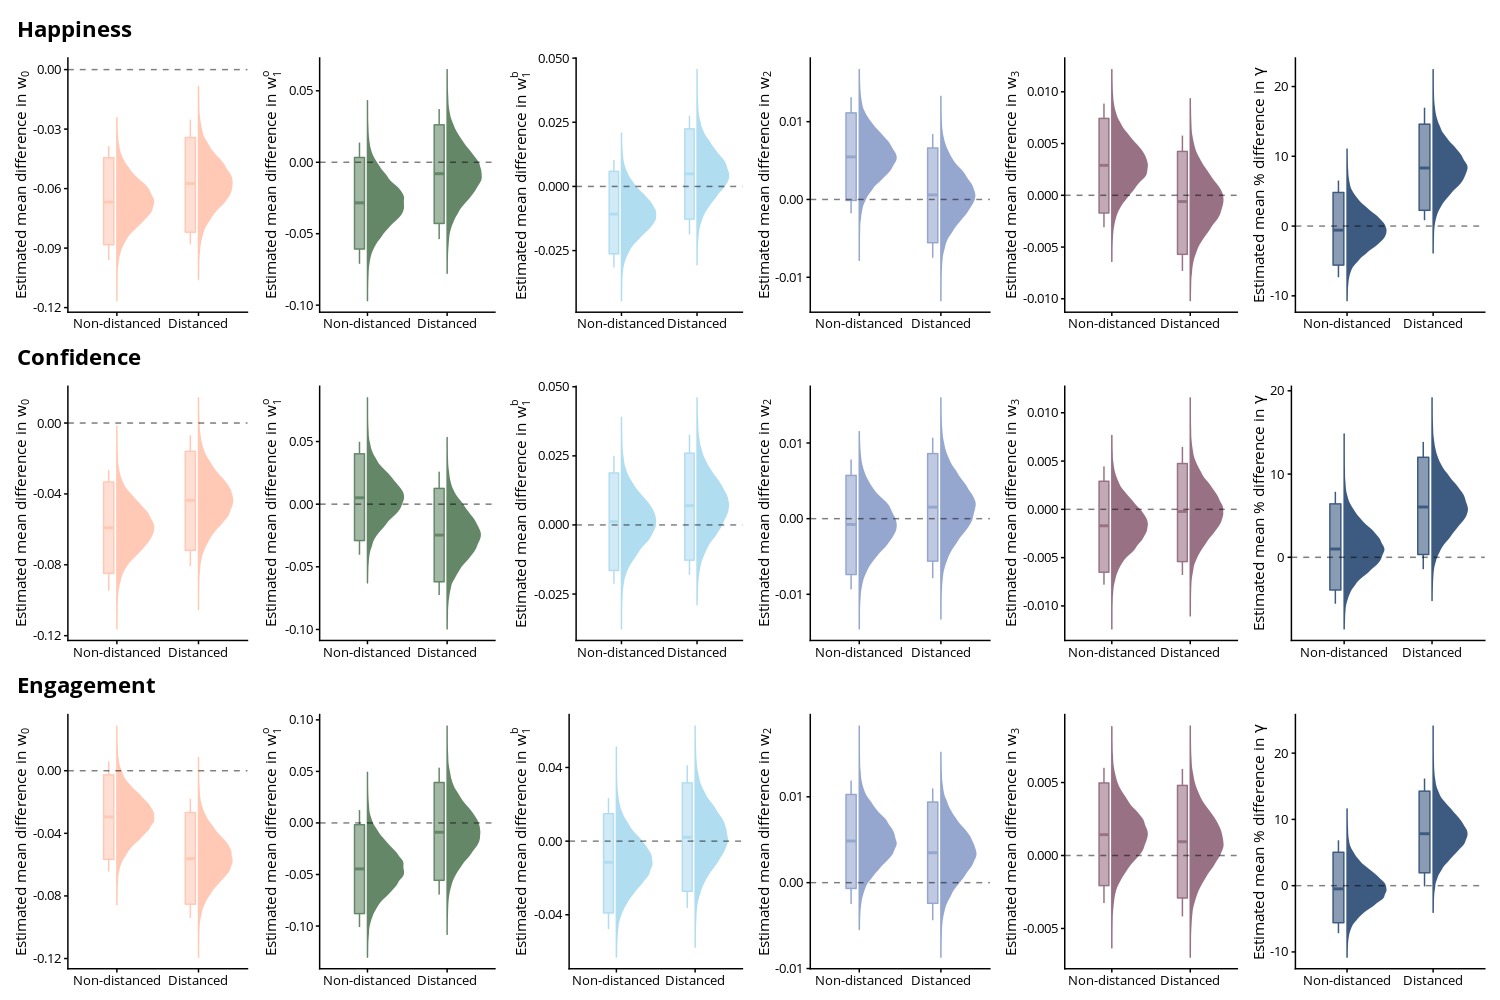

In [50]:
%%R -w 15 -h 10 --units in -r 100

AD_dist_plt_happy <- pstpipeline::plot_glm(
  AD_dist_int$happy, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_dist_plt_conf <- pstpipeline::plot_glm(
  AD_dist_int$confident, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_dist_plt_bored <- pstpipeline::plot_glm(
  AD_dist_int$engaged, plot_var = "AD", grp  = "distanced", grp_labs = c("Non-distanced", "Distanced"),
  coord_flip = FALSE, box_nudge = 0.1, font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_dist_plt_happy / AD_dist_plt_conf / AD_dist_plt_bored

These results suggest that the association between increases in anxiety/depression scores and lower baseline affect did not appear to differ between distanced and non-distanced individuals. However, interestingly, distanced individuals scoring higher in terms of anxiety/depression tended to integrate information from more trials in their incorporation of expected value and prediction error into their effect, though the evidence for this was strong only for engagement. Very speculatively, one could suggest that distancing specifically helped those with higher anxiety/depression symptoms to integrate information from wins and losses.

### Antidepressant usage

In [51]:
%%R
AD_antidep_int <- list()

AD_antidep_int$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_antidep_int$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

AD_antidep_int$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "AD",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  interaction = "antidepressant", 
  recode_na = 0,
  extra_data = factor_scores,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 4 finished in 2.6 seconds.
Chain 2 finished in 2.9 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 2.7 seconds.
Chain 4 finished in 2.7 seconds.
Chain 3 finished in 3.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 4 finished in 2.7 seconds.
Chain 2 finished in 3.0 seconds.
Chain 3 finished in 3.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.9 seconds.
Chain 1 finished in 3.2 seconds.
Chain 4 finished in 3.0 seconds.
Chain 3 finished in 3.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 2.7 seconds.
Chain 1 finished in 3.2 seconds.
Chain 2 finished in 3.1 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 21.2 seconds.
Chain 1 finished in 21.6 seconds.
Chain 3 finished in 22.2 seconds.
Chain 2 finished in 24.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 22.2 seconds.
Total execution time: 24.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 2 finished in 2.9 seconds.
Chain 3 finished in 2.8 seconds.
Chain 4 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 3 finished in 2.7 seconds.
Chain 4 finished in 3.0 seconds.
Chain 2 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 2.6 seconds.
Chain 4 finished in 2.7 seconds.
Chain 1 finished in 3.1 seconds.
Chain 2 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 3 finished in 2.9 seconds.
Chain 2 finished in 3.1 seconds.
Chain 4 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.8 seconds.
Chain 1 finished in 3.1 seconds.
Chain 4 finished in 2.8 seconds.
Chain 3 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 21.5 seconds.
Chain 4 finished in 23.1 seconds.
Chain 3 finished in 23.5 seconds.
Chain 2 finished in 24.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 23.1 seconds.
Total execution time: 24.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 3.0 seconds.
Chain 3 finished in 3.0 seconds.
Chain 1 finished in 3.3 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.8 seconds.
Chain 1 finished in 3.1 seconds.
Chain 4 finished in 3.1 seconds.
Chain 3 finished in 3.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 2 finished in 2.8 seconds.
Chain 3 finished in 2.9 seconds.
Chain 4 finished in 3.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 3 finished in 2.7 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 3.1 seconds.
Chain 3 finished in 3.6 seconds.
Chain 4 finished in 3.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.2 seconds.
Total execution time: 4.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 21.2 seconds.
Chain 3 finished in 24.7 seconds.
Chain 1 finished in 30.4 seconds.
Chain 2 finished in 31.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 27.0 seconds.
Total execution time: 31.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 2.7 seconds.
Chain 4 finished in 2.7 seconds.
Chain 3 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 3.0 seconds.
Chain 4 finished in 2.8 seconds.
Chain 2 finished in 3.0 seconds.
Chain 3 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 2 finished in 3.1 seconds.
Chain 4 finished in 2.9 seconds.
Chain 3 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 2.7 seconds.
Chain 2 finished in 3.2 seconds.
Chain 4 finished in 3.0 seconds.
Chain 1 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 2.9 seconds.
Chain 3 finished in 3.1 seconds.
Chain 4 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 22.2 seconds.
Chain 3 finished in 23.2 seconds.
Chain 1 finished in 24.7 seconds.
Chain 4 finished in 27.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 24.3 seconds.
Total execution time: 27.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 2.9 seconds.
Chain 3 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.8 seconds.
Chain 4 finished in 2.7 seconds.
Chain 1 finished in 3.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 3 finished in 2.7 seconds.
Chain 2 finished in 2.9 seconds.
Chain 4 finished in 2.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.7 seconds.
Chain 1 finished in 2.9 seconds.
Chain 3 finished in 3.0 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.9 seconds.
Chain 2 finished in 3.0 seconds.
Chain 4 finished in 3.1 seconds.
Chain 3 finished in 3.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.1 seconds.
Total execution time: 3.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 22.2 seconds.
Chain 4 finished in 23.8 seconds.
Chain 2 finished in 25.6 seconds.
Chain 3 finished in 31.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 25.6 seconds.
Total execution time: 31.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.6 seconds.
Chain 2 finished in 2.7 seconds.
Chain 3 finished in 3.1 seconds.
Chain 4 finished in 3.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.7 seconds.
Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.7 seconds.
Chain 4 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.7 seconds.
Chain 3 finished in 2.7 seconds.
Chain 1 finished in 3.0 seconds.
Chain 4 finished in 2.9 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.8 seconds.
Total execution time: 3.4 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 2.8 seconds.
Chain 2 finished in 2.9 seconds.
Chain 3 finished in 2.9 seconds.
Chain 4 finished in 3.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 2.9 seconds.
Total execution time: 3.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 2.9 seconds.
Chain 4 finished in 2.8 seconds.
Chain 3 finished in 3.0 seconds.
Chain 1 finished in 3.3 seconds.

All 4 chains finished successfully.
Mean chain execution time: 3.0 seconds.
Total execution time: 3.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 4 finished in 20.8 seconds.
Chain 1 finished in 22.7 seconds.
Chain 3 finished in 23.2 seconds.
Chain 2 finished in 23.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 22.6 seconds.
Total execution time: 23.9 seconds.


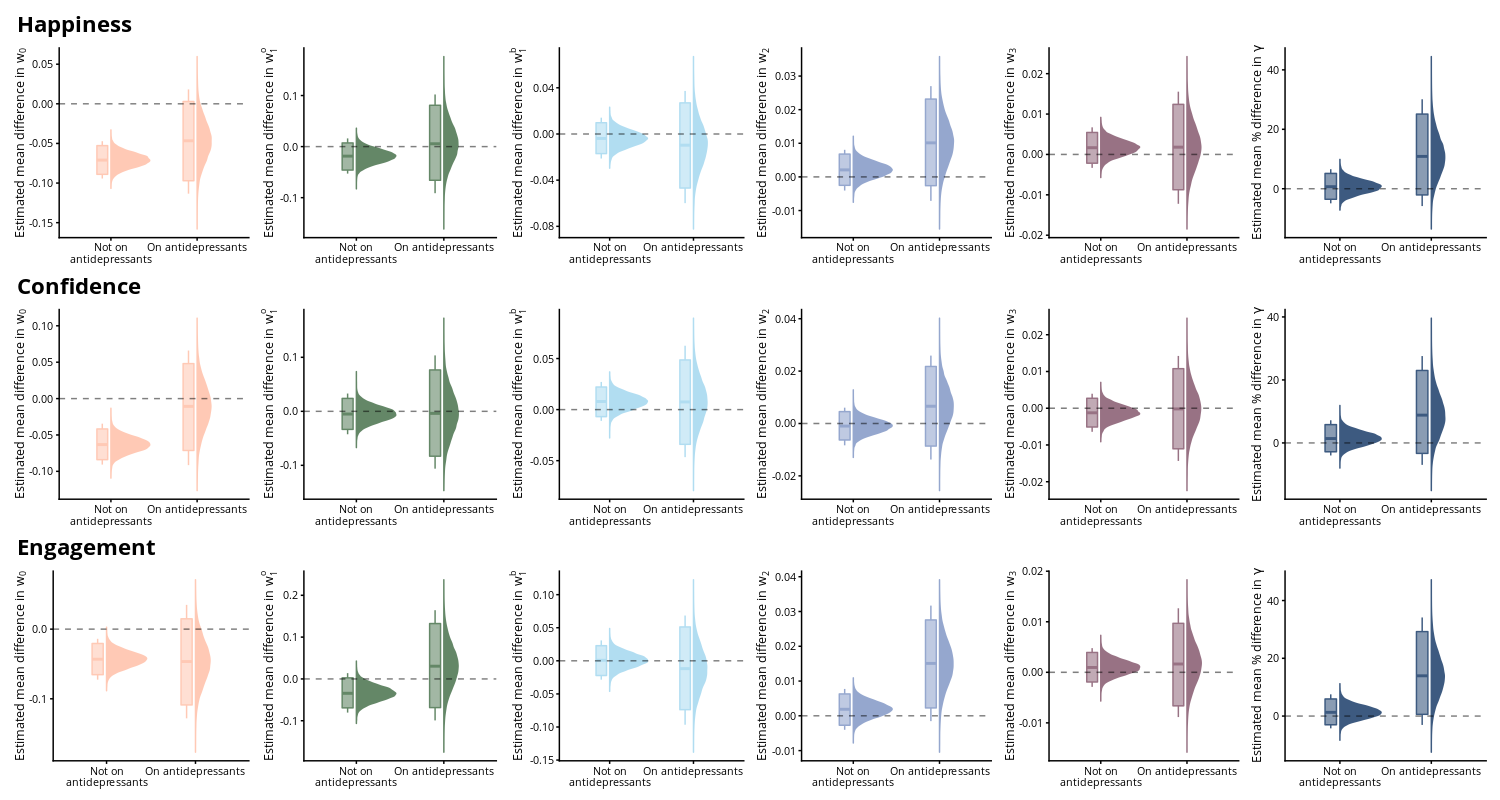

In [52]:
%%R -w 15 -h 8 --units in -r 100

AD_antidep_plt_happy <- pstpipeline::plot_glm(
  AD_antidep_int$happy, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
AD_antidep_plt_conf <- pstpipeline::plot_glm(
  AD_antidep_int$confident, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
AD_antidep_plt_bored <- pstpipeline::plot_glm(
  AD_antidep_int$engaged, plot_var = "AD", grp = "antidepressant", grp_labs = c("Not on\nantidepressants", "On antidepressants"),
  coord_flip = FALSE, box_nudge = 0.1, font_size = 9, font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

AD_antidep_plt_happy / AD_antidep_plt_conf / AD_antidep_plt_bored

Interestingly, we find that the negative association between baseline affect and anxiety/depression scores is not seen in those currently taking antidepressant. In addition, we see evidence of a similar effect on the decay factor $\gamma$ to cognitive distancing, whereby increases in anxiety/depression scores are associated with increased $\gamma$ only in those on antidepressants, though the evidence for this is weaker.

In [53]:
%%R
explore_AD_grp <- list()
explore_AD_grp$AD_dist_int <- AD_dist_int
explore_AD_grp$AD_antidep_int <- AD_antidep_int

saveRDS(explore_AD_grp, "outputs/cmdstan/affect_1a/outcome_glms/exploratory_AD_interaction_models.RDS")

## Exploratory analysis 2: Associations between model parameters and self-reported fatigue

One final point of interest is whether self-reported fatigue, which was reported between 0 and 100 at the end of each block in response to the question *"How **fatigued** do you feel compared to the beginning of the block?"*, related to the model parameters. Here we look at two quantities - the mean post-block fatigue score, which should correlate with $w^b_1$, and the per-block change in this post-block fatigue score (i.e., coefficient from regression of fatigue score on trial block), which may perhaps relate more to the overall decay in affect ($w^o_1$).

In [54]:
%%R
all_res_split <- readRDS("data-raw/all_res_split.RDS")

fatigue <- dplyr::bind_rows(
    all_res_split$non_distanced$training, 
    all_res_split$distanced$training
  ) |>
  dplyr::filter(!is.na(fatigue_response)) |>
  dplyr::mutate(fatigue_response = fatigue_response / 10) |>
    # so now unit increase = 10%
  dplyr::select(subjID, trial_block, fatigue_response)

fatigue_data <- data.table::rbindlist(
  lapply(
  unique(fatigue$subjID),
  function (s) {
    coefs <- lm(fatigue_response ~ trial_block, data = subset(fatigue, subjID == s))$coefficients
    return(tibble::tibble(
      "subjID" = s,
      "mu_post_block_fatigue" = mean(subset(fatigue, subjID == s)$fatigue_response), 
      "delta_post_block_fatigue" = ifelse(is.na(coefs[[2]]), 0, coefs[[2]])
    ))
  }
))

### Association between mean post-block fatigue and model parameters

In [55]:
%%R
post_block_fatigue <- list()

post_block_fatigue$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 1,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 2,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "mu_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced"),
  affect_number = 3,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.5 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 6.8 seconds.
Chain 1 finished in 7.0 seconds.
Chain 3 finished in 7.0 seconds.
Chain 4 finished in 7.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.0 seconds.
Total execution time: 7.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.5 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 4 finished in 6.9 seconds.
Chain 2 finished in 7.2 seconds.
Chain 3 finished in 7.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.1 seconds.
Total execution time: 7.5 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.4 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.8 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.7 seconds.
Chain 4 finished in 1.7 seconds.
Chain 3 finished in 2.0 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.8 seconds.
Total execution time: 2.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.0 seconds.
Chain 2 finished in 6.9 seconds.
Chain 4 finished in 7.0 seconds.
Chain 3 finished in 7.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.0 seconds.
Total execution time: 7.5 seconds.


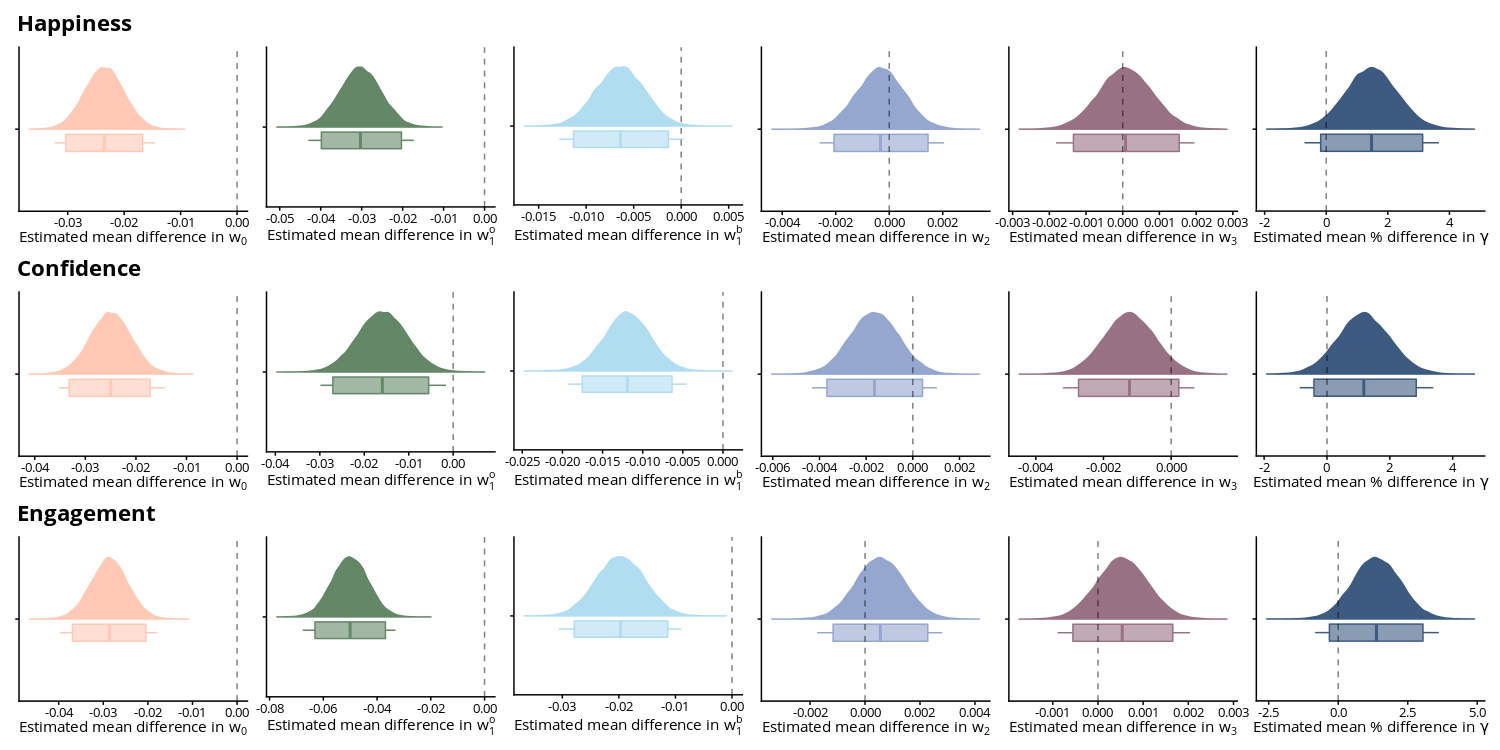

In [56]:
%%R -w 15 -h 7.5 --units in -r 100

fatigue_plt_happy <- pstpipeline::plot_glm(
  post_block_fatigue$happy, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
fatigue_plt_conf <- pstpipeline::plot_glm(
  post_block_fatigue$confident, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
fatigue_plt_bored <- pstpipeline::plot_glm(
  post_block_fatigue$engaged, plot_var = "mu_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

fatigue_plt_happy / fatigue_plt_conf / fatigue_plt_bored

Perhaps unsurprisingly, self-reported post-block fatigue is strongly negatively associated with both $w^o_1$ and $w^b_1$ across all three affect ratings. In addition, it is also strongly associated with baseline ratings for all three affect adjectives, though it should be noted there is limited evidence of an strong positive association between any of the factor scores and post-block fatigue ($r$=0.05-0.11), the effects of which on $w_0$ appear independent of fatigue.

### Association between *change* in post-block fatigue ratings and model parameters

Note that we also control for mean overall fatigue ratings here, as clearly baseline fatigue and interpretations of the scale will differ.

In [57]:
%%R
post_block_fatigue_change <- list()

post_block_fatigue_change$happy <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 1,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue_change$confident <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 2,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

post_block_fatigue_change$engaged <- pstpipeline::parameter_glm(
  summary_df = list(summary_df_5wt_nd, summary_df_5wt_dis),
  raw_df = list(raw_df_5wt_nd, raw_df_5wt_dis),
  var_of_interest = "delta_post_block_fatigue",
  covariates = c("age", "sex", "digit_span", "distanced", 
                 "mu_post_block_fatigue"),
  affect_number = 3,
  extra_data = fatigue_data,
  iter_warmup = 2000, iter_sampling = 10000
)

R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.8 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.7 seconds.
Chain 2 finished in 1.8 seconds.
Chain 4 finished in 1.6 seconds.
Chain 3 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.8 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.3 seconds.
Chain 2 finished in 7.2 seconds.
Chain 4 finished in 7.2 seconds.
Chain 3 finished in 7.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.3 seconds.
Total execution time: 7.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.4 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.4 seconds.
Chain 3 finished in 1.5 seconds.
Chain 4 finished in 1.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 1.9 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 2 finished in 1.4 seconds.
Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.1 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 2 finished in 1.7 seconds.
Chain 3 finished in 1.7 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.3 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 7.3 seconds.
Chain 3 finished in 7.3 seconds.
Chain 4 finished in 7.3 seconds.
Chain 2 finished in 8.4 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.6 seconds.
Total execution time: 8.7 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.5 seconds.
Chain 2 finished in 1.5 seconds.
Chain 3 finished in 1.6 seconds.
Chain 4 finished in 1.8 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.6 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.4 seconds.
Chain 2 finished in 1.6 seconds.
Chain 4 finished in 1.5 seconds.
Chain 3 finished in 1.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.5 seconds.
Total execution time: 2.0 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.6 seconds.
Chain 3 finished in 1.6 seconds.
Chain 2 finished in 1.8 seconds.
Chain 4 finished in 1.6 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.7 seconds.
Total execution time: 2.2 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 1 finished in 1.8 seconds.
Chain 2 finished in 1.8 seconds.
Chain 3 finished in 1.9 seconds.
Chain 4 finished in 2.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 1.9 seconds.
Total execution time: 2.6 seconds.


R[write to console]: Model executable is up to date!



Running MCMC with 4 parallel chains...

Chain 3 finished in 7.1 seconds.
Chain 1 finished in 7.5 seconds.
Chain 4 finished in 7.2 seconds.
Chain 2 finished in 7.7 seconds.

All 4 chains finished successfully.
Mean chain execution time: 7.4 seconds.
Total execution time: 8.0 seconds.


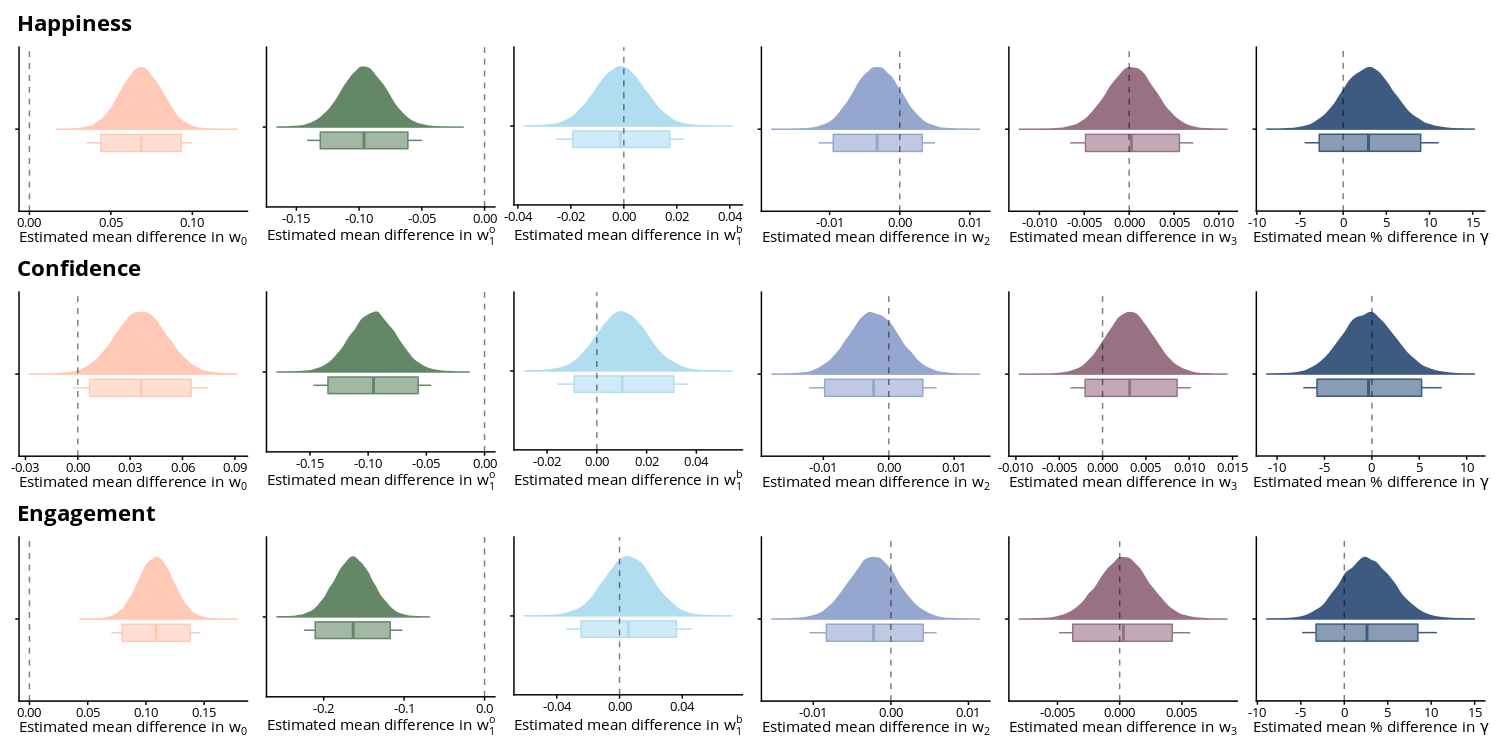

In [58]:
%%R -w 15 -h 7.5 --units in -r 100

fatigue_change_plt_happy <- pstpipeline::plot_glm(
  post_block_fatigue_change$happy, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Happiness"
)
fatigue_change_plt_conf <- pstpipeline::plot_glm(
  post_block_fatigue_change$confident, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Confidence"
)
fatigue_change_plt_bored <- pstpipeline::plot_glm(
  post_block_fatigue_change$engaged, plot_var = "delta_post_block_fatigue", font = "Open Sans", pal = pal, ovrll_title = "Engagement"
)

fatigue_change_plt_happy / fatigue_change_plt_conf / fatigue_change_plt_bored

Indeed, as suspected, there is a negative assocaition between change in post-block fatigue (i.e., where positive coefficients = more tired at the end of the block) and $w^o_1$. In addition, interestingly, increased declines were associated with higher baseline affect, especially engagement which may perhaps represent an effect of motivation - participants who were more motivated and engaged towards the beginning of the task also exerted more effort throughout the task, resulting in greater overall increases in fatigue and decreases in affect.

In [59]:
%%R
explore_fatigue <- list()
explore_fatigue$post_block_fatigue <- post_block_fatigue
explore_fatigue$post_block_fatigue_change <- post_block_fatigue_change

saveRDS(explore_fatigue, "outputs/cmdstan/affect_1a/outcome_glms/exploratory_fatigue_models.RDS")